In [1]:
from AC_modules.BatchedA2C import MoveToBeaconSpatialA2C
from Utils.train_batched_A2C import *
from Utils.A2C_inspection import *
import AC_modules.Networks as net
import torch
import numpy as np
import matplotlib.pyplot as plt

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [14]:
def test(step_idx, agent, test_env, process_ID, num_test=5):
    score = 0.0
    done = False
    
    ### Standard tests ###
    for _ in range(num_test-1):
        
        obs = test_env.reset()
        s = get_ohe_state(obs)[np.newaxis, ...] # add batch dim
        available_actions = obs[0].observation.available_actions
        a_mask = get_action_mask(available_actions)[np.newaxis, ...] # add batch dim
        
        while not done:
            a, log_prob, probs = agent.step(s, a_mask)
            obs = test_env.step(a)
            s_prime = get_ohe_state(obs)[np.newaxis, ...] # add batch dim
            reward = obs[0].reward
            done = obs[0].last()
            available_actions = obs[0].observation.available_actions
            a_mask = get_action_mask(available_actions)[np.newaxis, ...] # add batch dim
            
            s = s_prime
            score += reward
        done = False
        
    ### Inspection test ###
    G, inspector = inspection_test(step_idx, agent, test_env, process_ID)
    score += G
    print(f"Step # : {step_idx}, avg score : {score/num_test:.1f}")
    return score/num_test, inspector

In [26]:
def inspection_test(step_idx, agent, test_env, process_ID):
    inspector = InspectionDict(step_idx, process_ID)
    
    obs = test_env.reset()
    s = get_ohe_state(obs)[np.newaxis, ...] # add batch dim
    
    available_actions = obs[0].observation.available_actions
    a_mask = get_action_mask(available_actions)[np.newaxis, ...] # add batch dim
    
    done = False
    G = 0.0
    # list used for update
    s_lst, r_lst, done_lst, bootstrap_lst, s_trg_lst = list(), list(), list(), list(), list()
    log_probs = []
    distributions = []
    while not done:
        inspector.dict['state_traj'].append(s)
        a, log_prob, probs, step_dict = inspection_step(agent, s, a_mask)
        inspector.store_step(step_dict)
        log_probs.append(log_prob)
        distributions.append(probs)
        
        obs = test_env.step(a)
        s_prime = get_ohe_state(obs)[np.newaxis, ...] # add batch dim
        reward = obs[0].reward
        done = obs[0].last()
        available_actions = obs[0].observation.available_actions
        a_mask = get_action_mask(available_actions)[np.newaxis, ...] # add batch dim
        if done:
            bootstrap = True
        else:
            bootstrap = False
            
        s_lst.append(s)
        r_lst.append(reward)
        done_lst.append(done)
        bootstrap_lst.append(bootstrap)
        s_trg_lst.append(s_prime)
            
        s = s_prime
        G += reward
        
    inspector.dict['rewards'] = r_lst
    s_lst = np.array(s_lst).transpose(1,0,2,3,4)
    r_lst = np.array(r_lst).reshape(1,-1)
    done_lst = np.array(done_lst).reshape(1,-1)
    bootstrap_lst = np.array(bootstrap_lst).reshape(1,-1)
    s_trg_lst = np.array(s_trg_lst).transpose(1,0,2,3,4)    
    update_dict = inspection_update(agent, r_lst, log_probs, distributions, s_lst, 
                                    done_lst, bootstrap_lst, s_trg_lst)
    inspector.store_update(update_dict)
    return G, inspector

In [4]:
RESOLUTION = 16
MAX_STEPS = 256
game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 

In [5]:
test_env = init_game(game_params, max_steps=MAX_STEPS)

In [6]:
agent = torch.load("Results/MoveToBeacon/agent_COYJ")

In [27]:
PID = "COYJ"
step_idx = 1200000
score, inspector = inspection_test(step_idx, agent, test_env, PID)

In [28]:
inspector.dict.keys()

dict_keys(['state_traj', 'action_distr', 'action_sel', 'queue_distr', 'queue_sel', 'selectall_distr', 'selectall_sel', 'spatial_distr', 'spatial_sel', 'values', 'trg_values', 'critic_losses', 'advantages', 'actor_losses', 'rewards'])

In [16]:
avg_score, inspector = test(step_idx, agent, test_env, PID)

Step # : 1200000, avg score : 4.8


# Update variables visualization 

In [18]:
timesteps = np.arange(len(inspector.dict['values']))

In [36]:
def plot_rewards(rewards):
    r = np.array(rewards).astype(bool)
    spikes = np.arange(len(r))[r]
    flag = True
    for s in spikes:
        if flag:
            plt.axvline(s, alpha=0.7, c='g', label='rewards')
            flag = False
        else:
            plt.axvline(s, alpha=0.7, c='g')

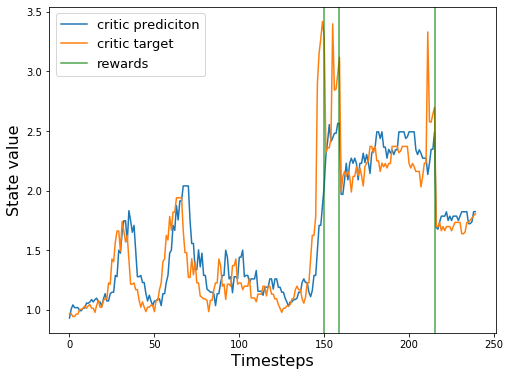

In [37]:
plt.figure(figsize=(8,6))
plt.plot(timesteps, inspector.dict['values'], label='critic prediciton')
plt.plot(timesteps, inspector.dict['trg_values'], label='critic target')
plot_rewards(inspector.dict['rewards'])
plt.legend(fontsize=13)
plt.xlabel('Timesteps', fontsize=16)
plt.ylabel('State value', fontsize=16)
plt.show()

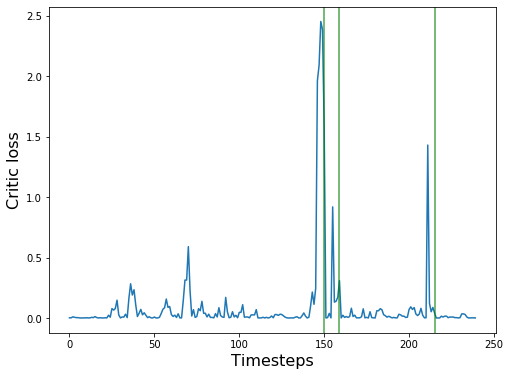

In [38]:
plt.figure(figsize=(8,6))
plt.plot(timesteps, inspector.dict['critic_losses'])
plot_rewards(inspector.dict['rewards'])
plt.xlabel('Timesteps', fontsize=16)
plt.ylabel('Critic loss', fontsize=16)
plt.show()

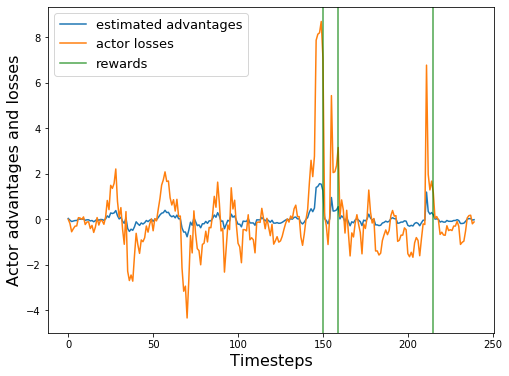

In [39]:
plt.figure(figsize=(8,6))
plt.plot(timesteps, inspector.dict['advantages'], label='estimated advantages')
plt.plot(timesteps, inspector.dict['actor_losses'], label='actor losses')
plot_rewards(inspector.dict['rewards'])
plt.legend(loc='upper left', fontsize=13)
plt.xlabel('Timesteps', fontsize=16)
plt.ylabel('Actor advantages and losses', fontsize=16)
plt.show()

# Frame by frame visualization

In [108]:
def plot_state(d, t):
    PLAYER_COLOR = np.array([200,10,10])
    BEACON_COLOR = np.array([10,10,100])
    BACKGROUND_COLOR = np.array([10,100,10])
    
    s = d['state_traj'][t][0]
    rgb_map = np.full(s.shape[-2:]+(3,), BACKGROUND_COLOR)
    
    beacon_ys, beacon_xs = s[1].nonzero()
    player_y, player_x = s[0].nonzero()
    selected = s[2][player_y, player_x]
    
    rgb_map[beacon_ys, beacon_xs] = BEACON_COLOR
    rgb_map[player_y, player_x] = PLAYER_COLOR
    
    plt.imshow(rgb_map)
    plt.xticks([])
    plt.yticks([])

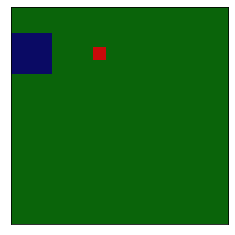

In [96]:
plot_state(inspector.dict, t)

In [102]:
def plot_screen_distr(d, t):
    probs = d['spatial_distr'][t]
    plt.imshow(probs, 'plasma')
    plt.xticks([])
    plt.yticks([])
    #plt.colorbar()

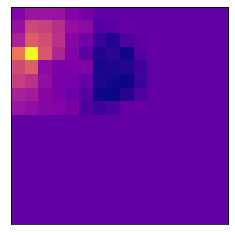

In [103]:
plot_screen_distr(inspector.dict, 40)

In [109]:
def plot_screen_and_decision(d, t):
    fig = plt.figure(figsize=(14,6))
    
    plt.subplot(121)
    plot_state(d, t)
    
    plt.subplot(122)
    plot_screen_distr(d, t)
    
    plt.show()

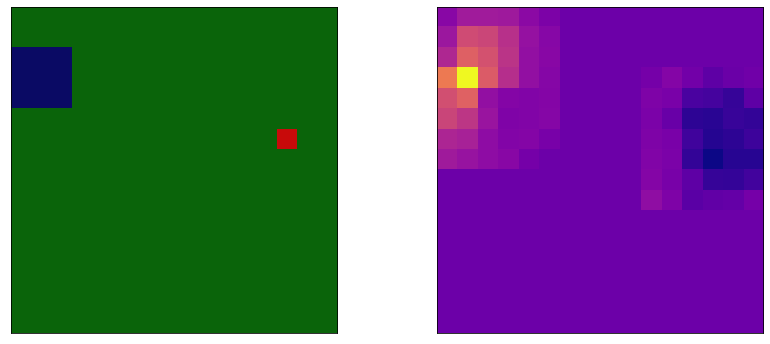

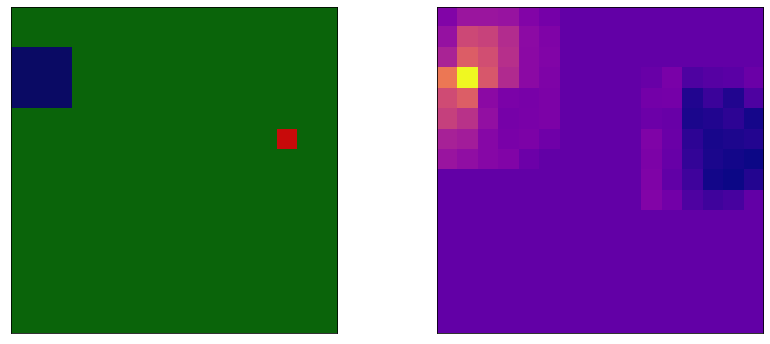

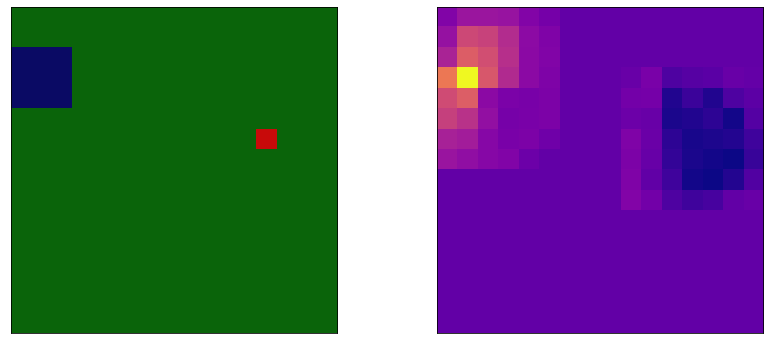

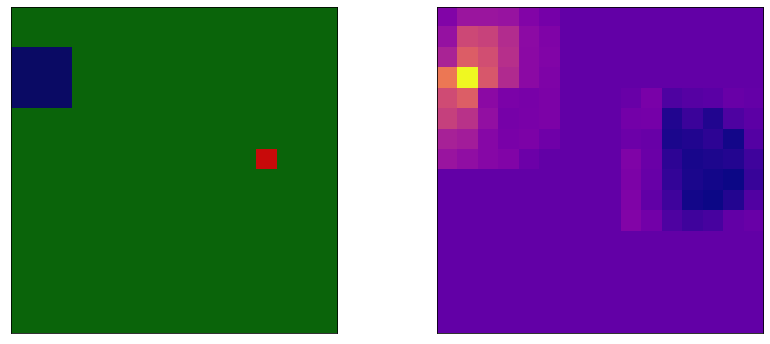

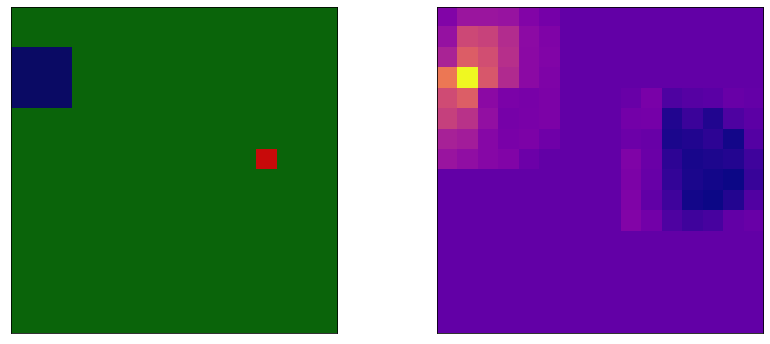

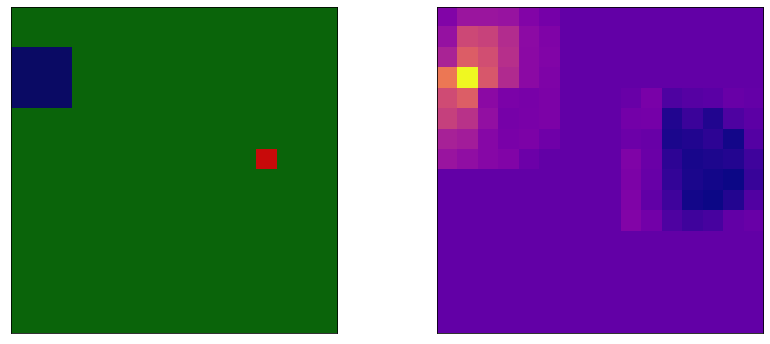

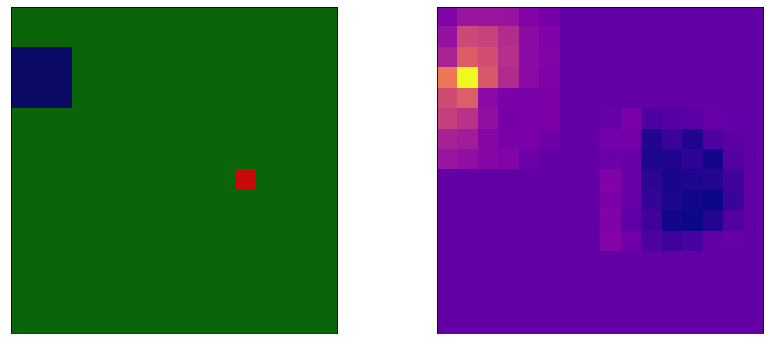

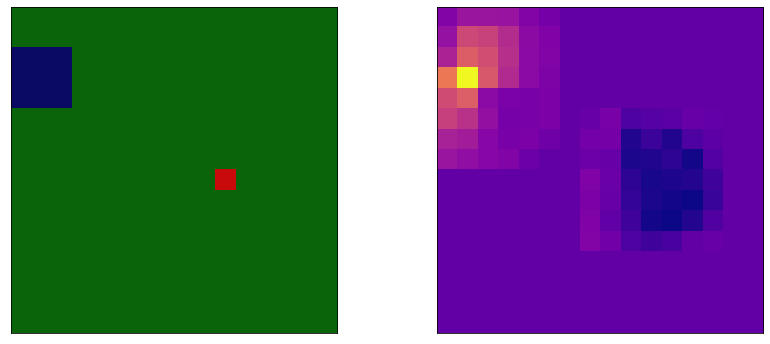

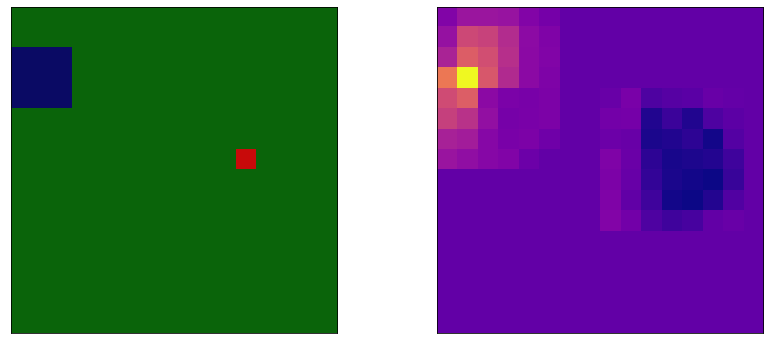

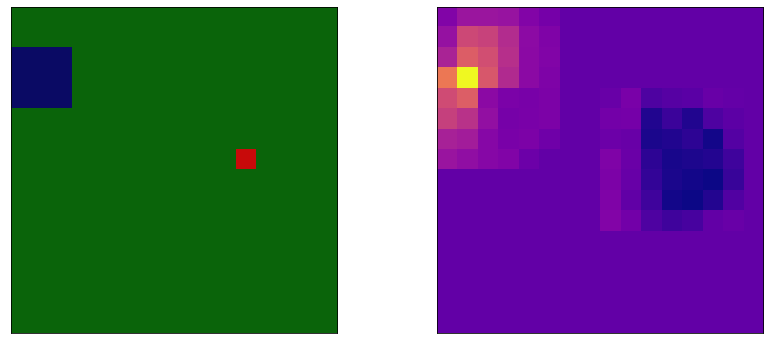

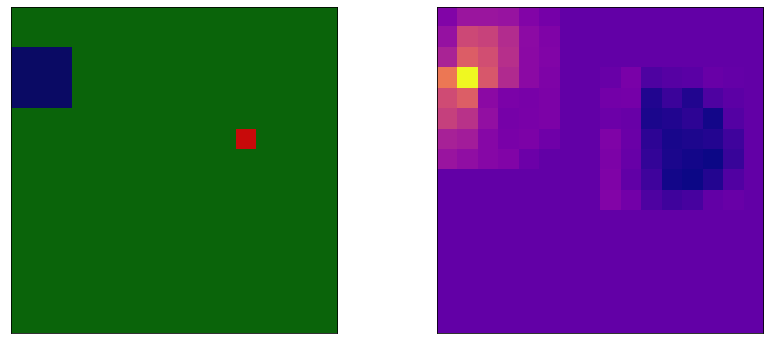

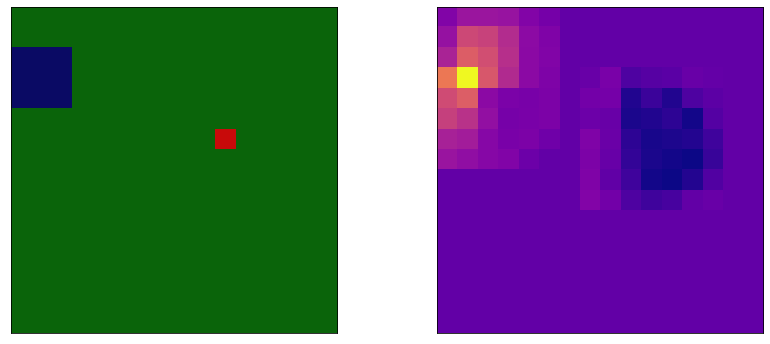

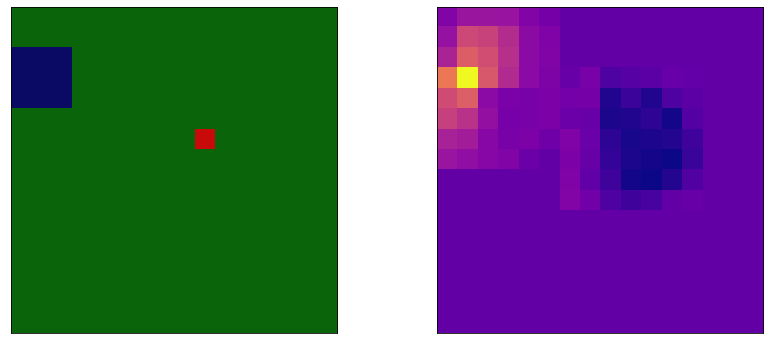

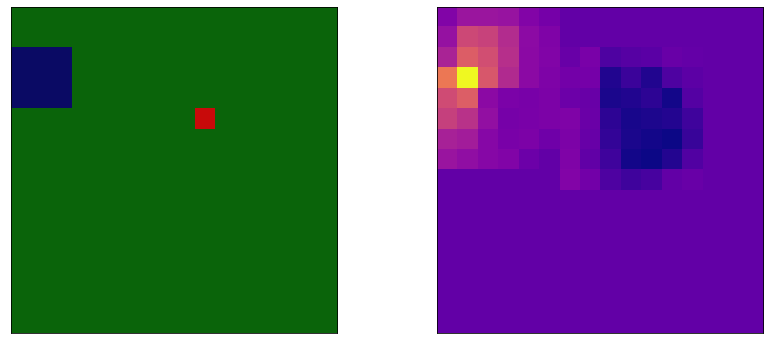

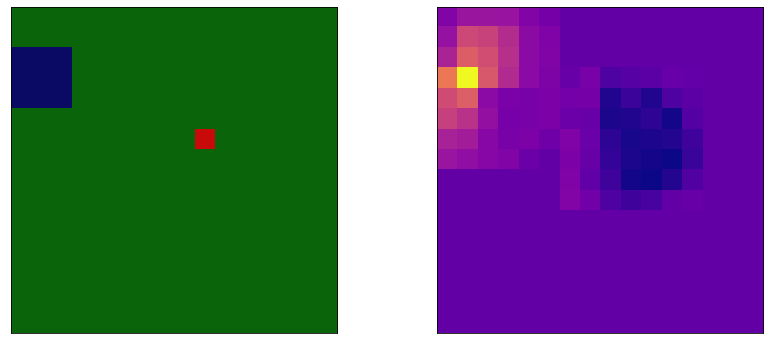

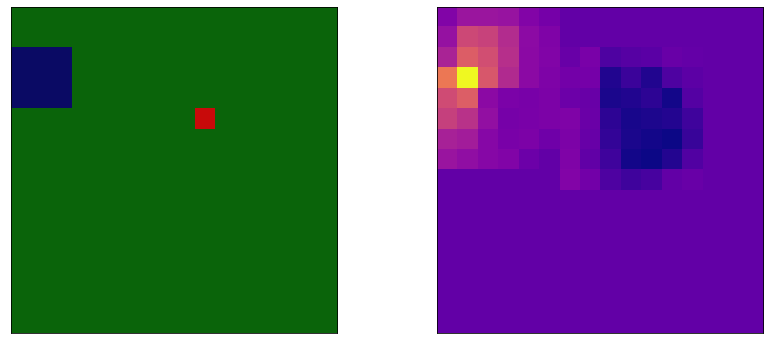

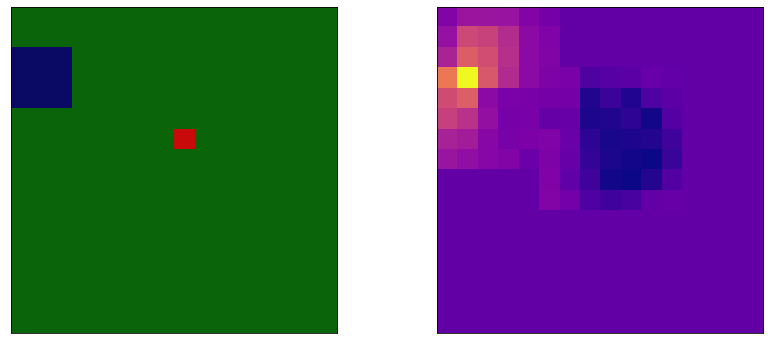

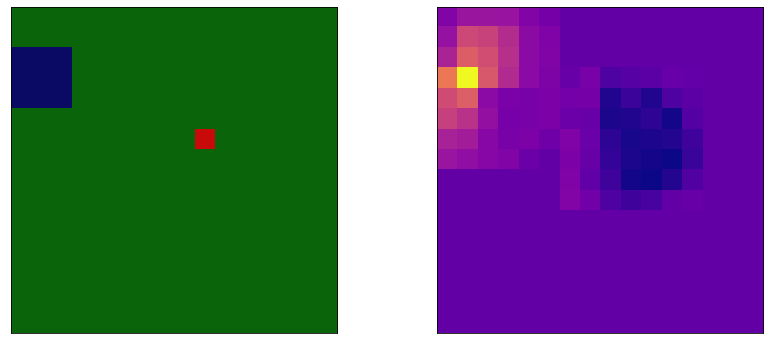

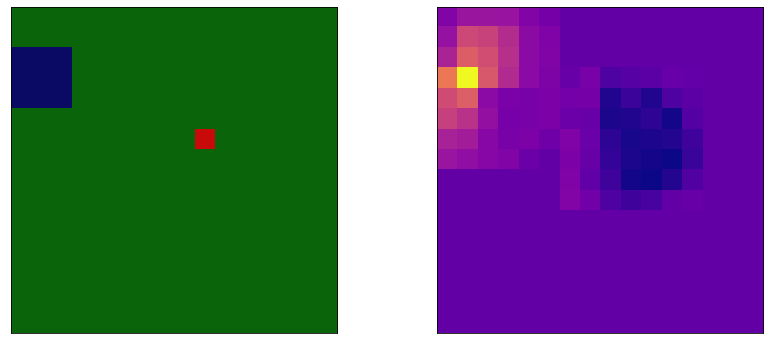

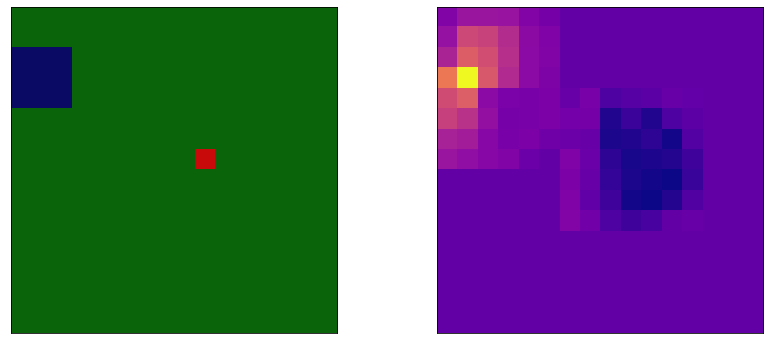

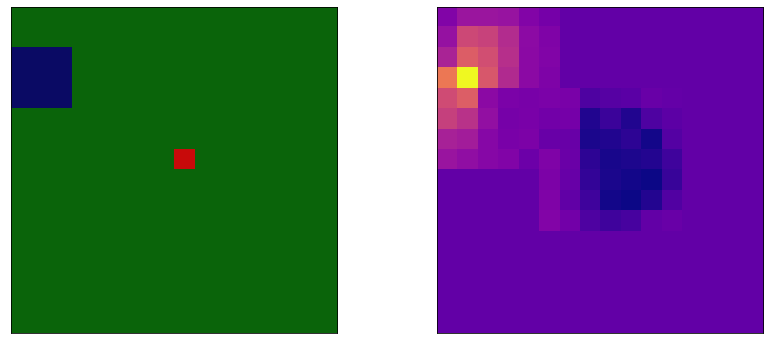

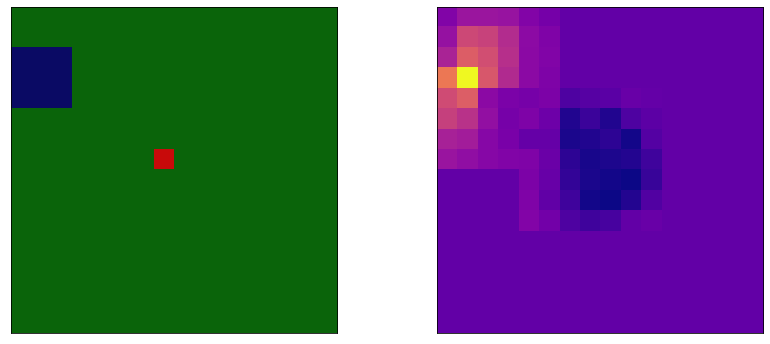

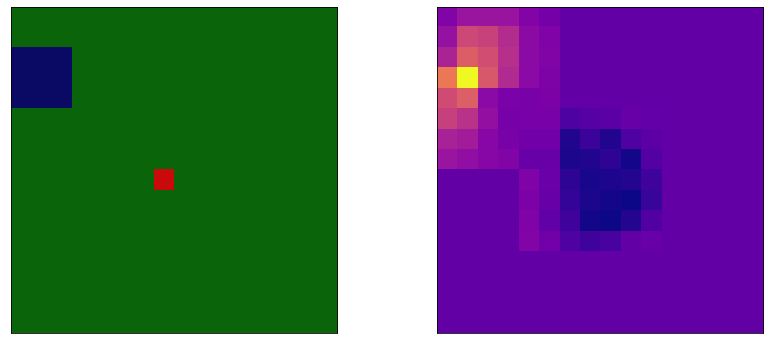

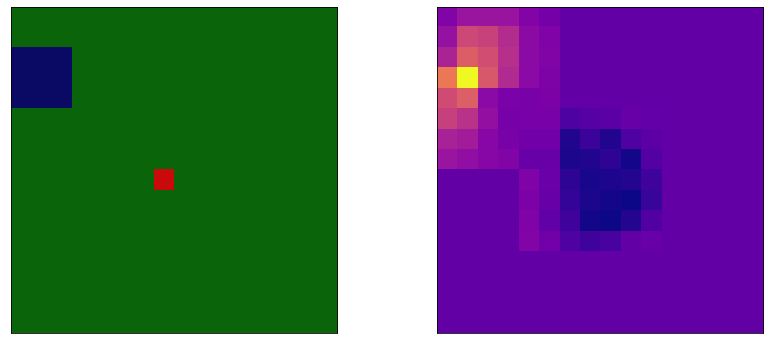

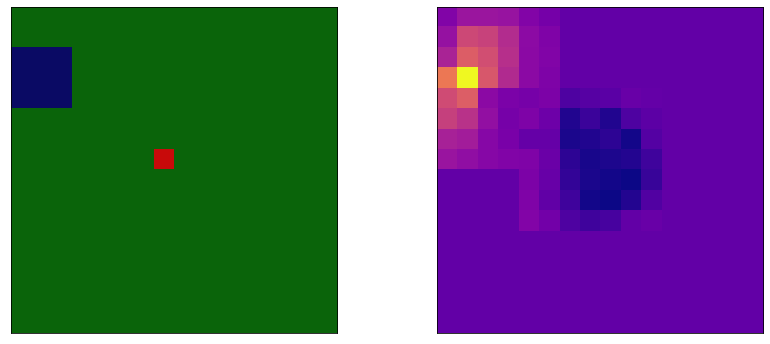

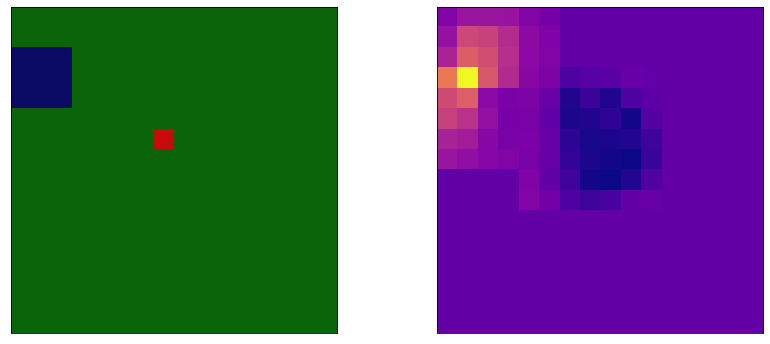

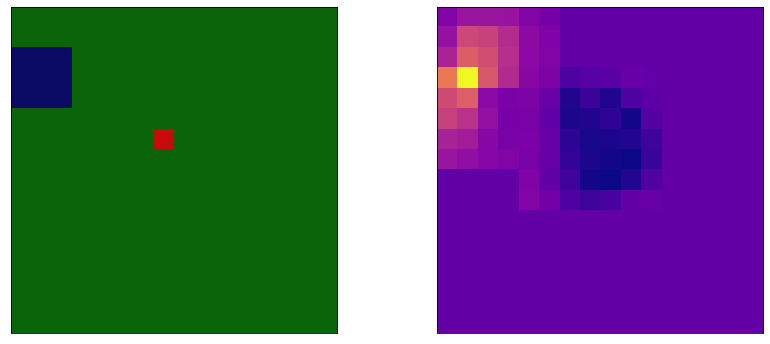

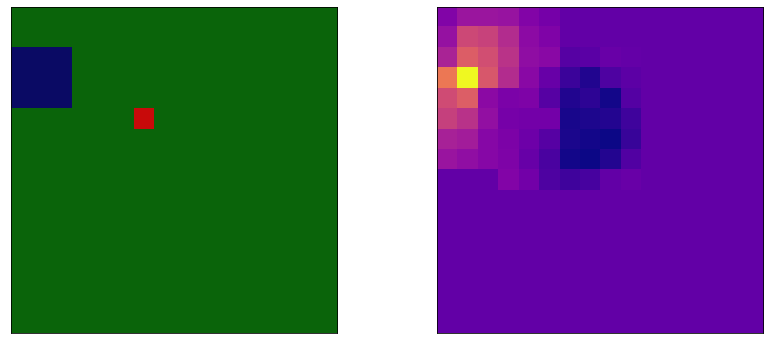

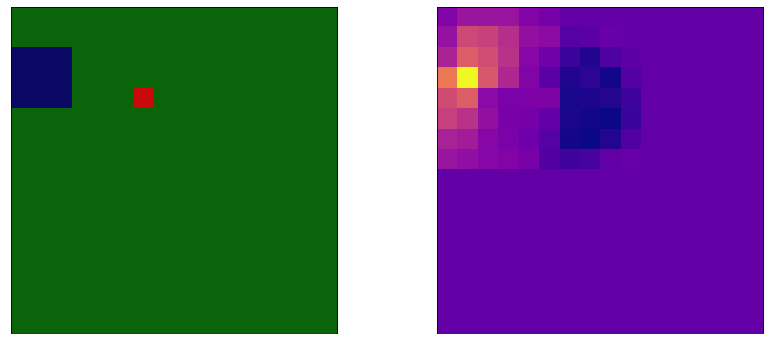

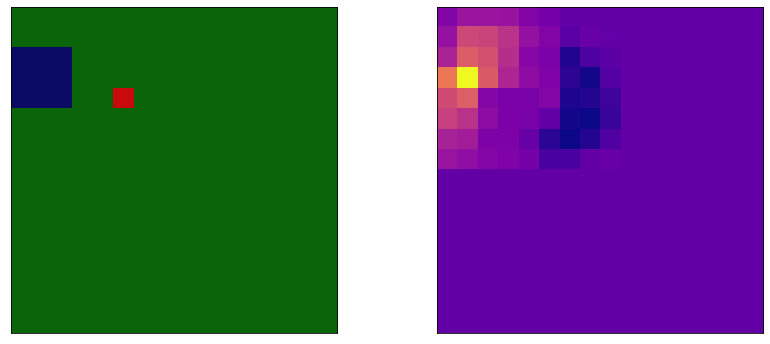

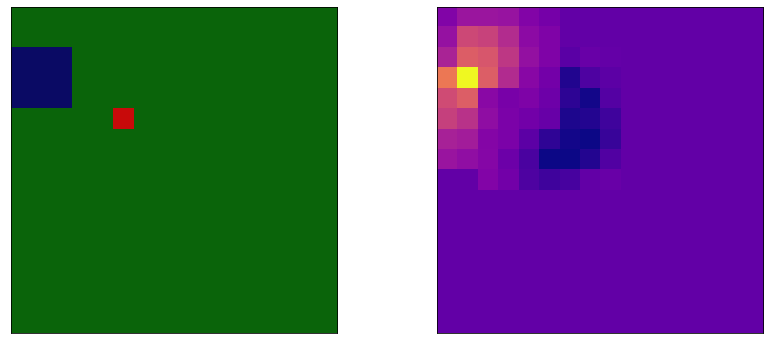

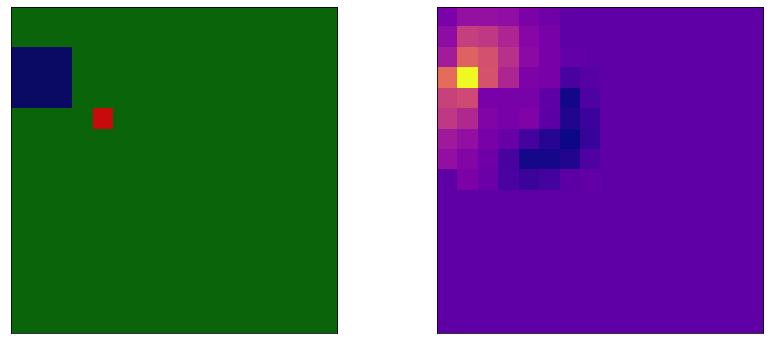

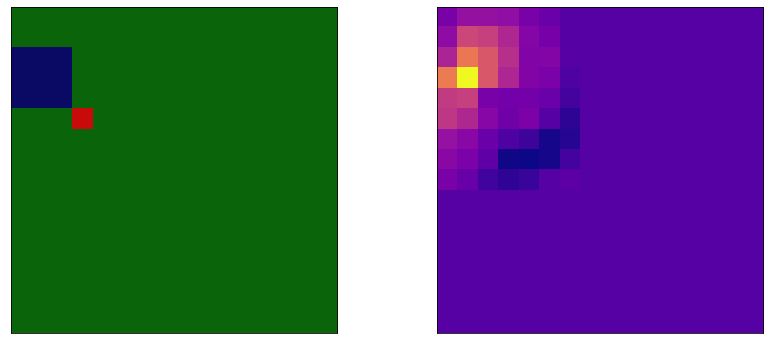

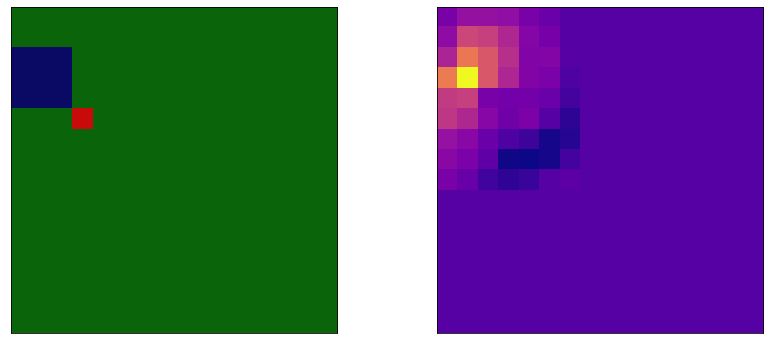

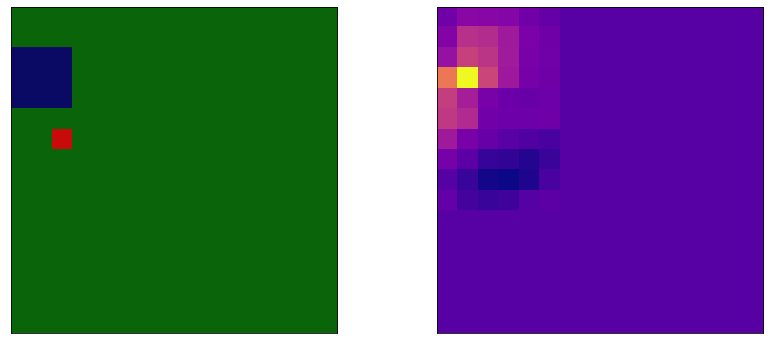

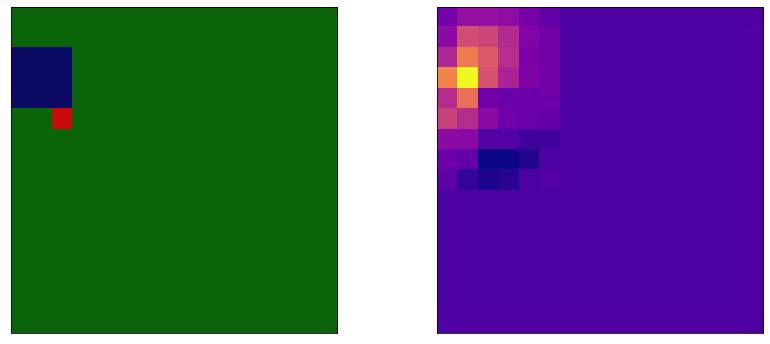

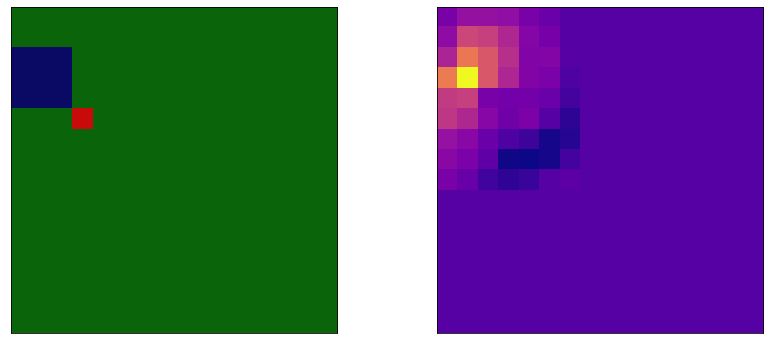

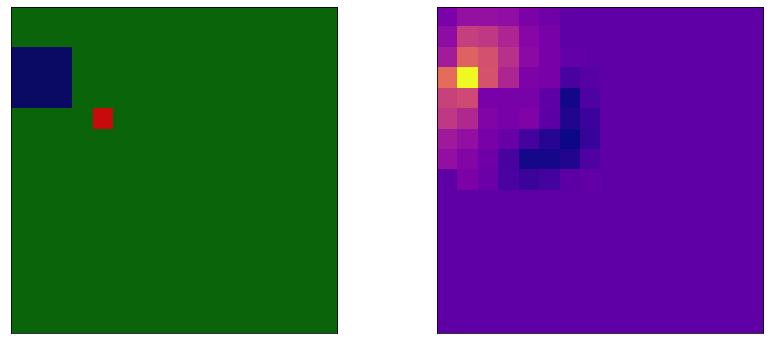

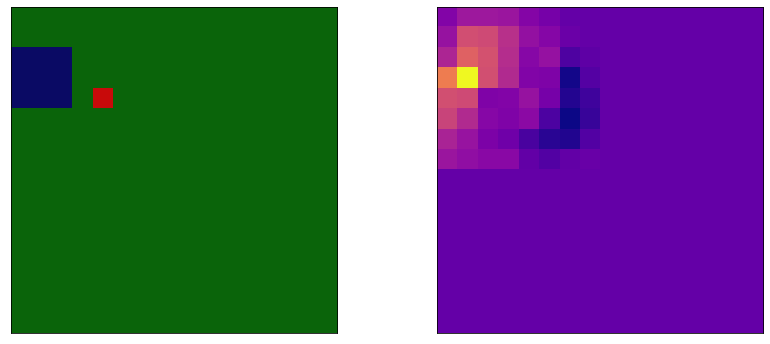

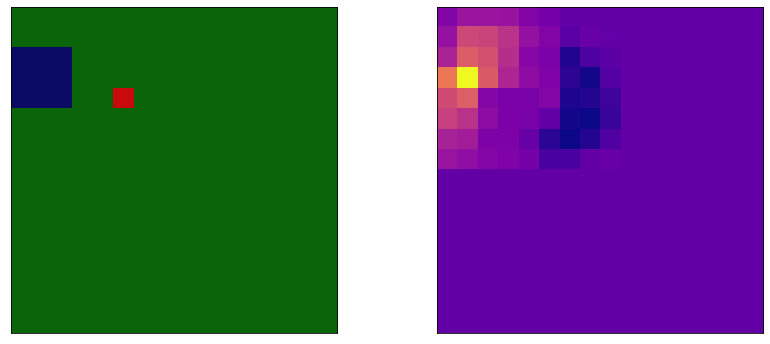

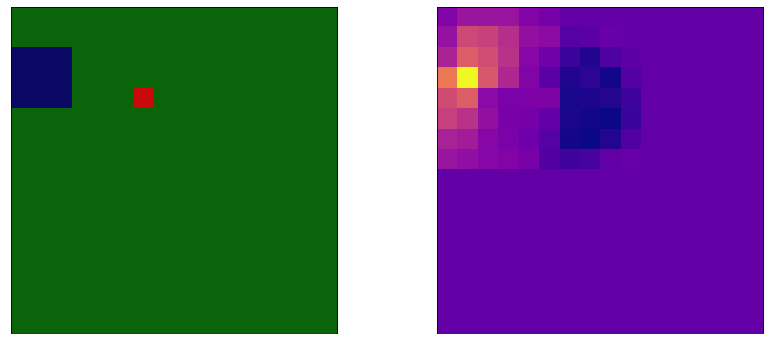

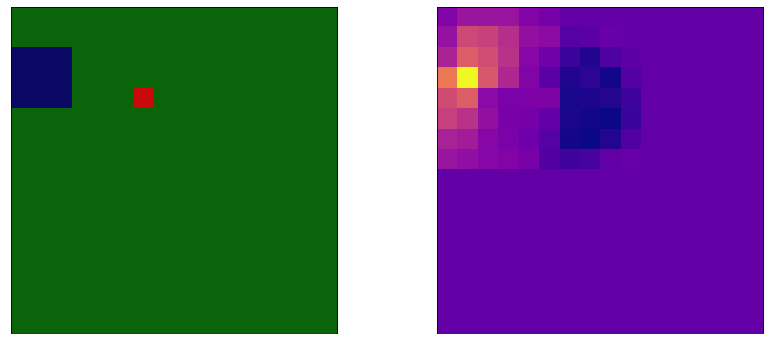

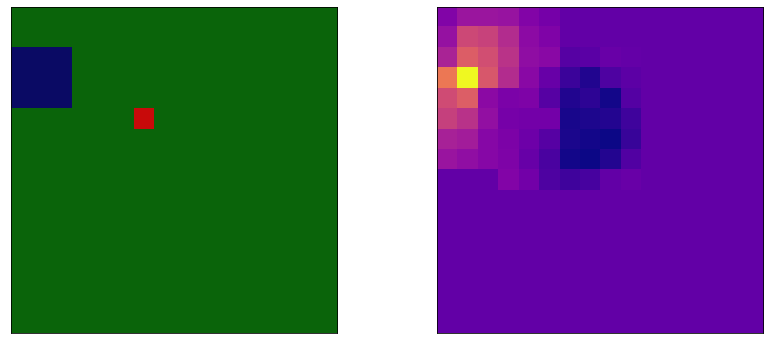

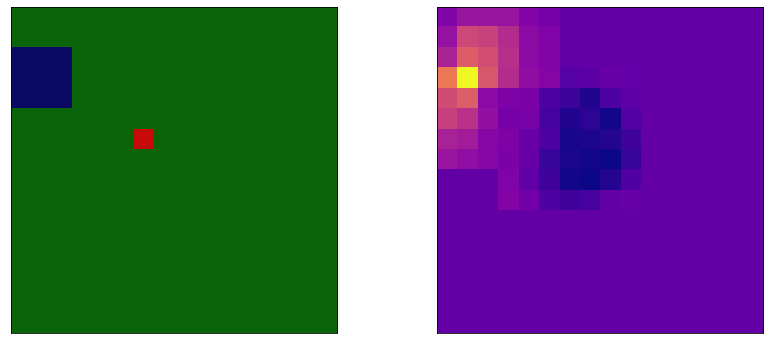

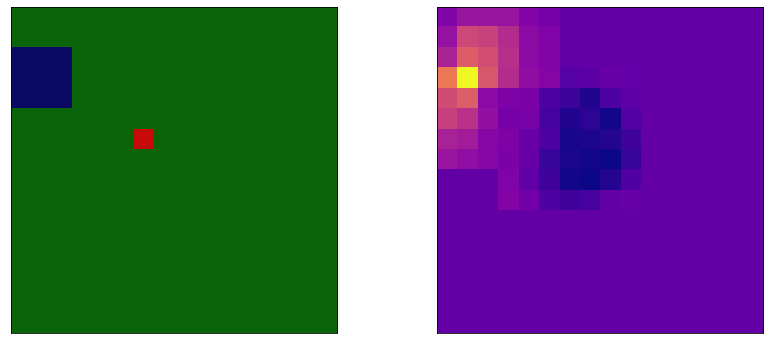

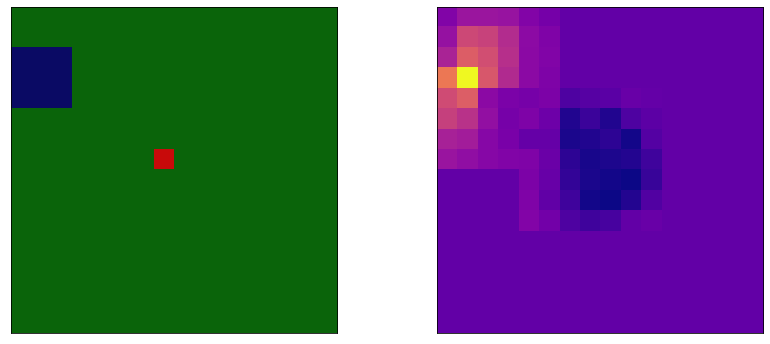

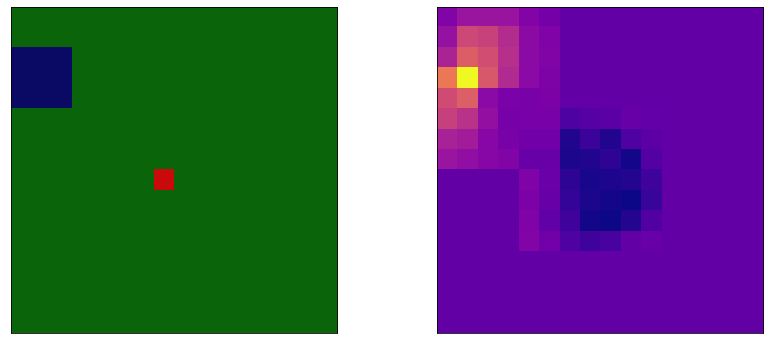

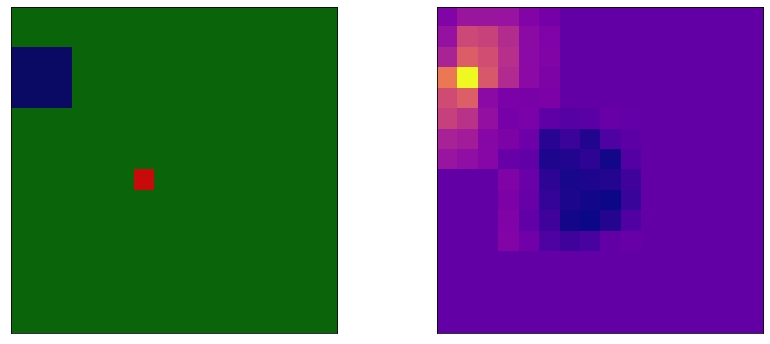

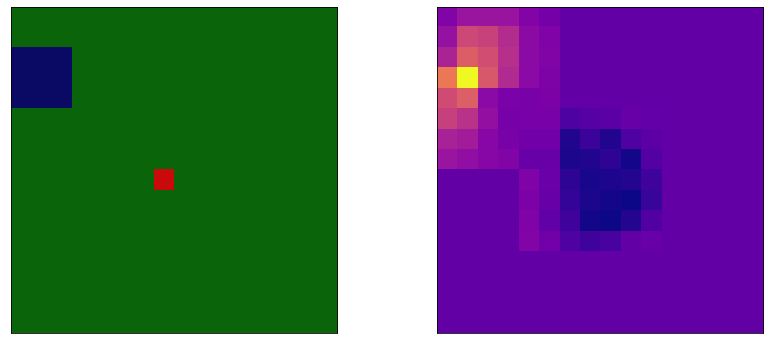

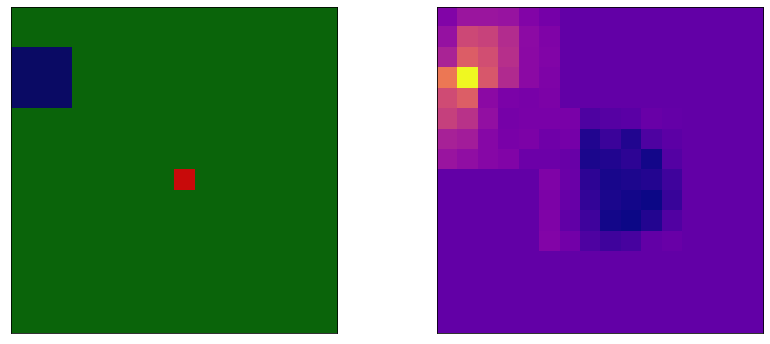

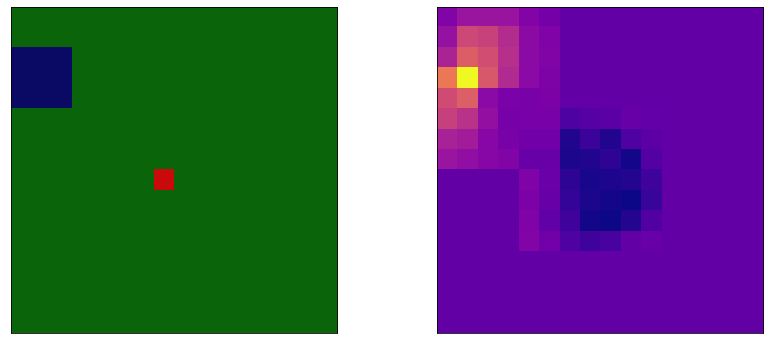

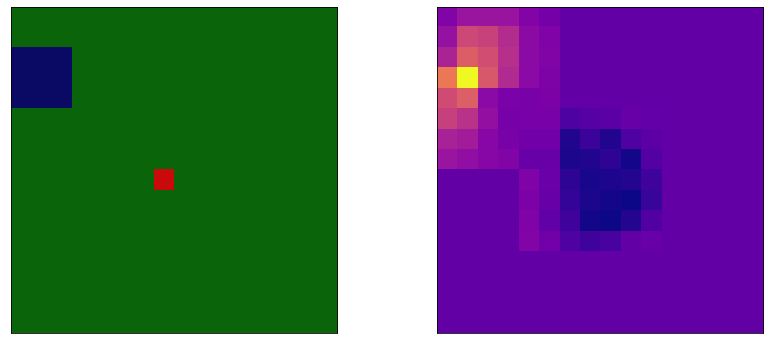

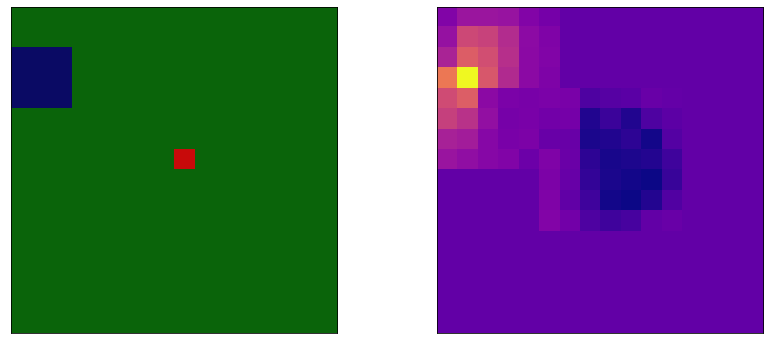

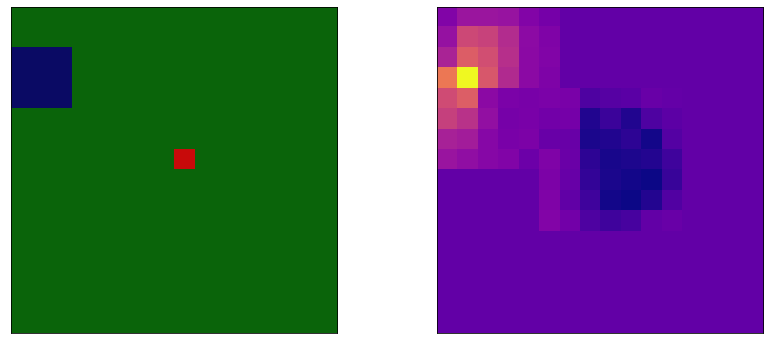

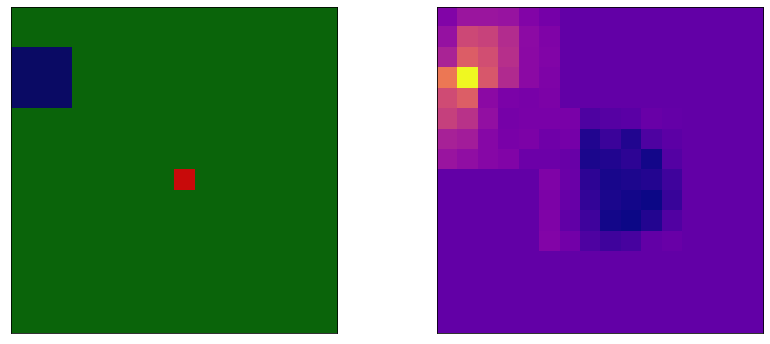

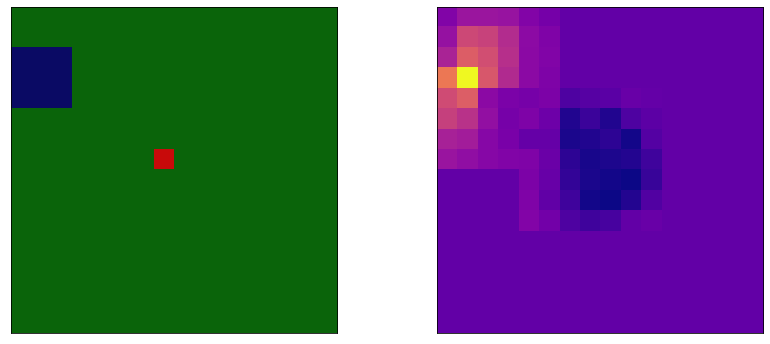

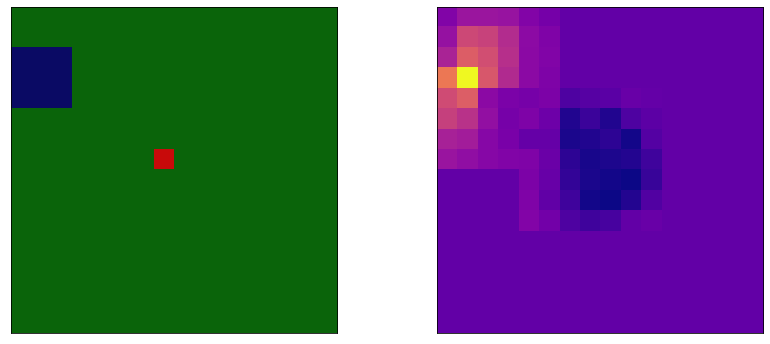

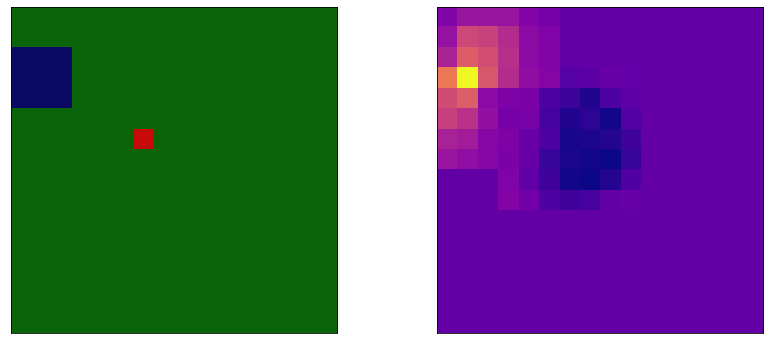

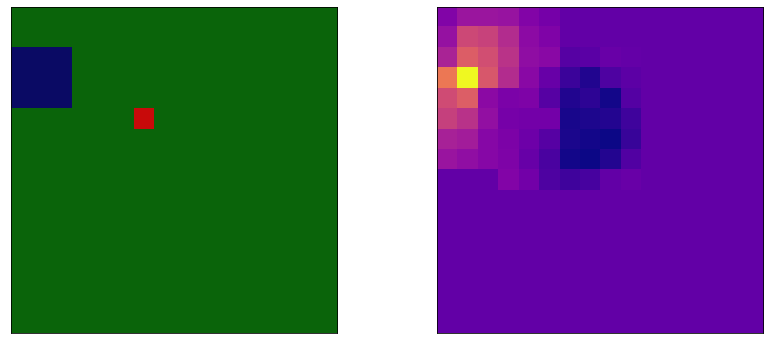

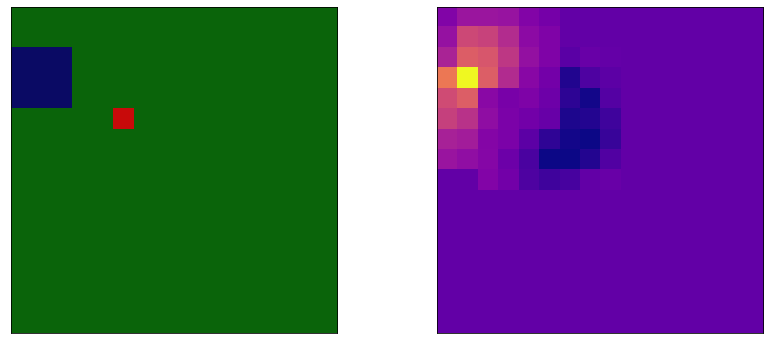

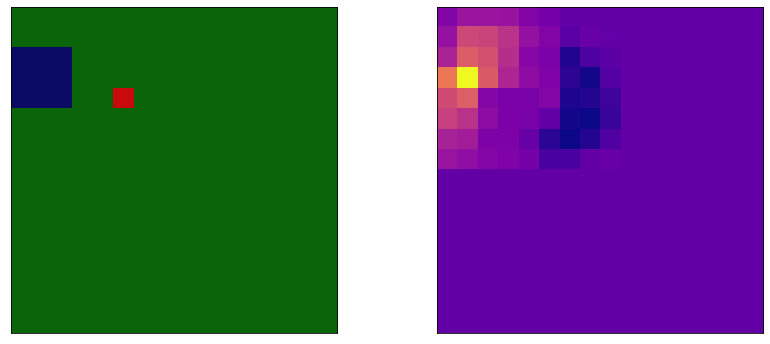

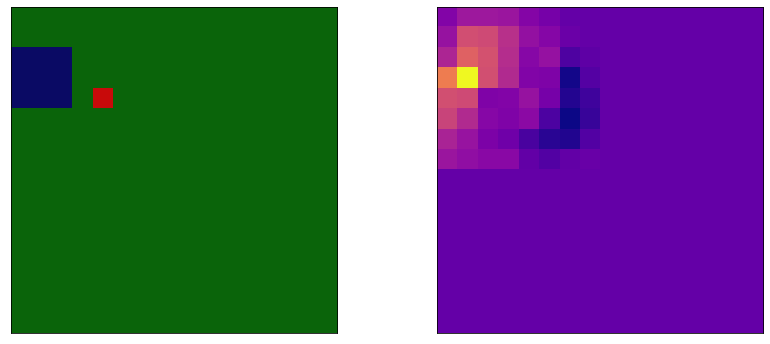

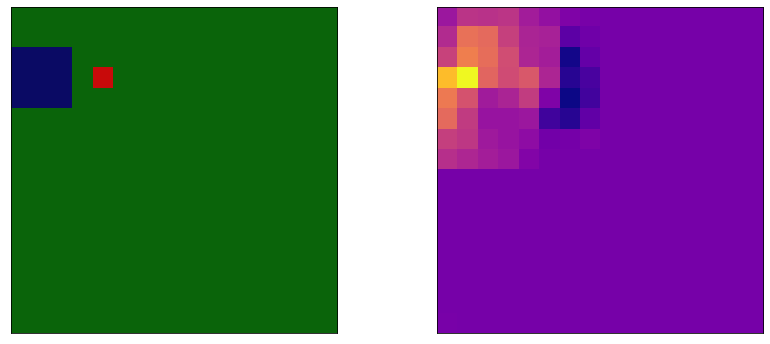

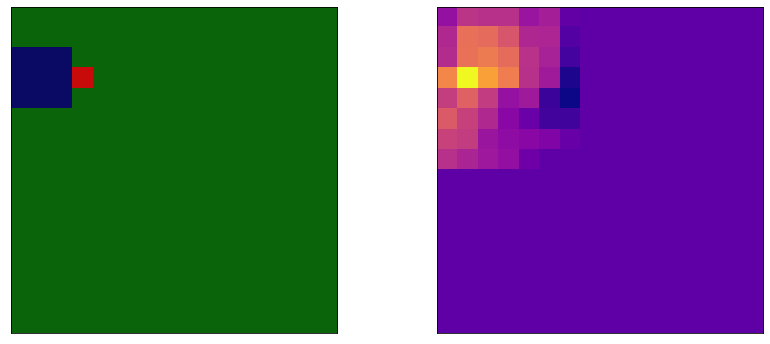

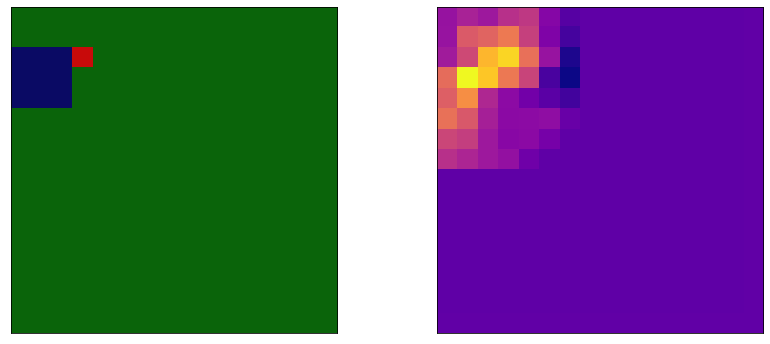

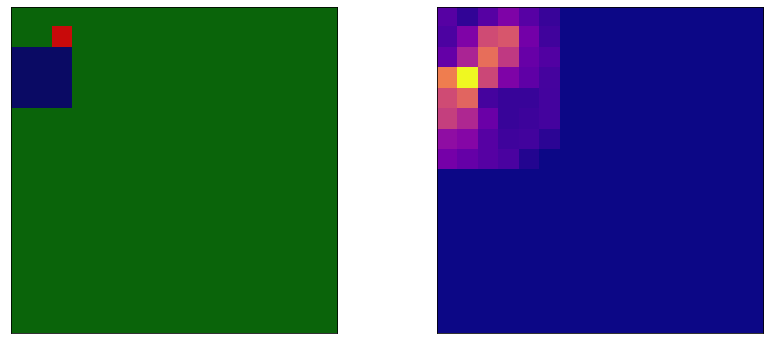

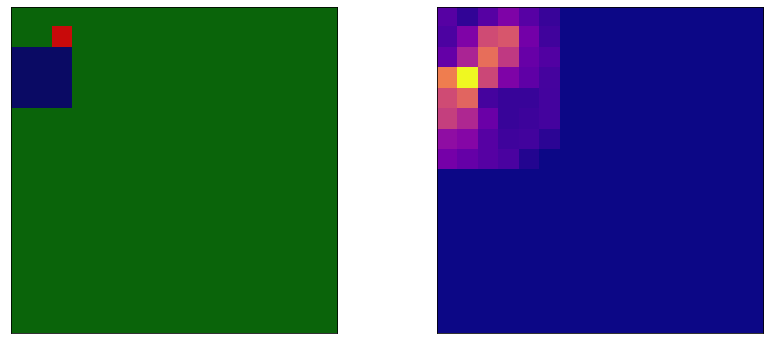

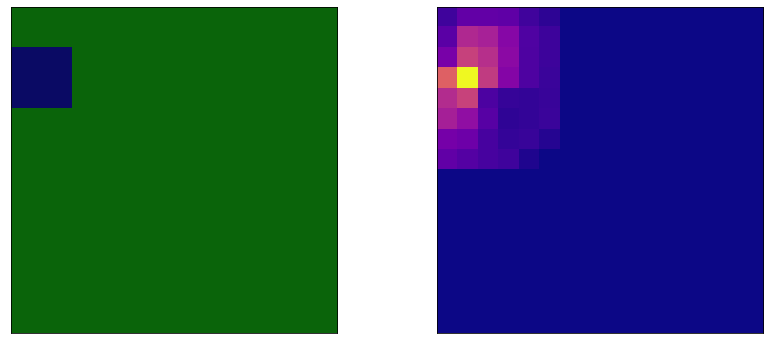

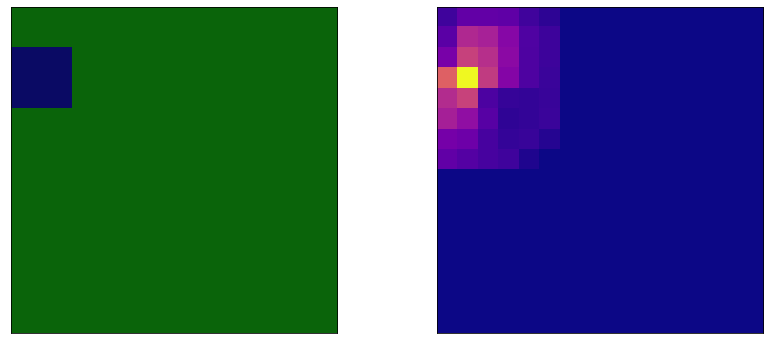

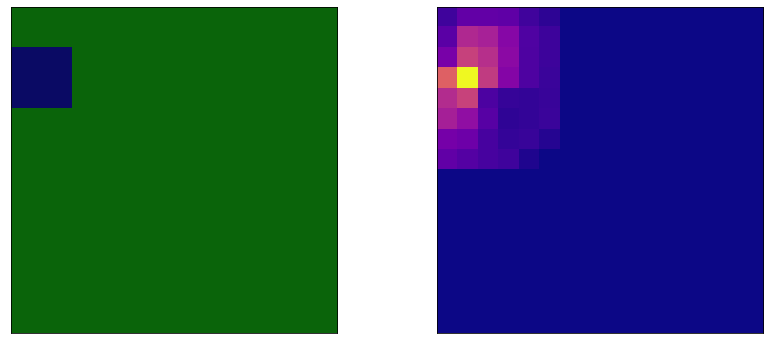

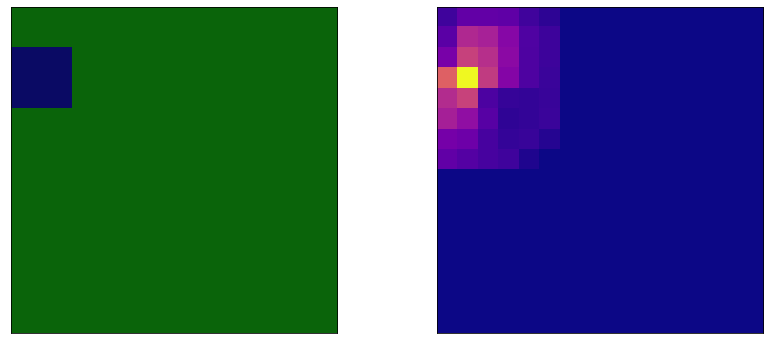

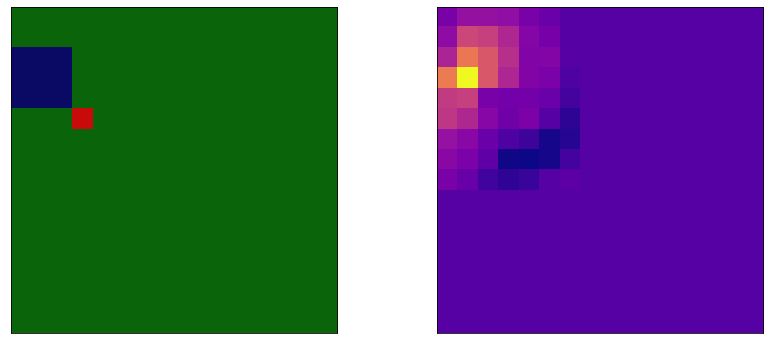

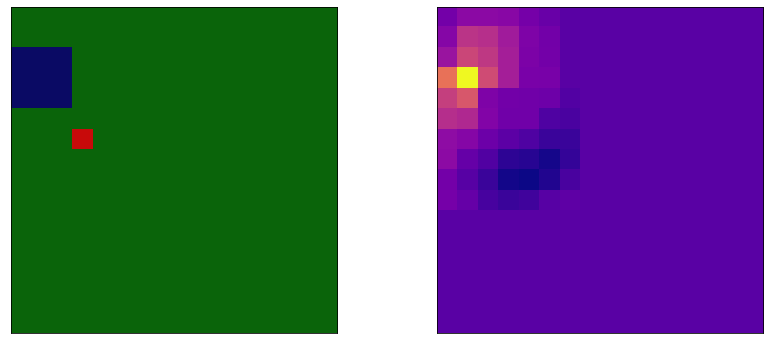

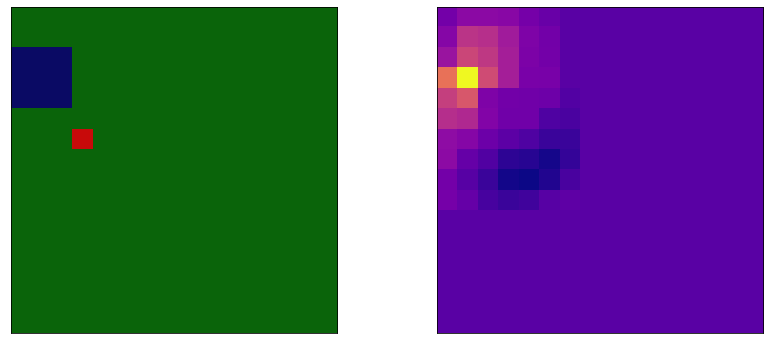

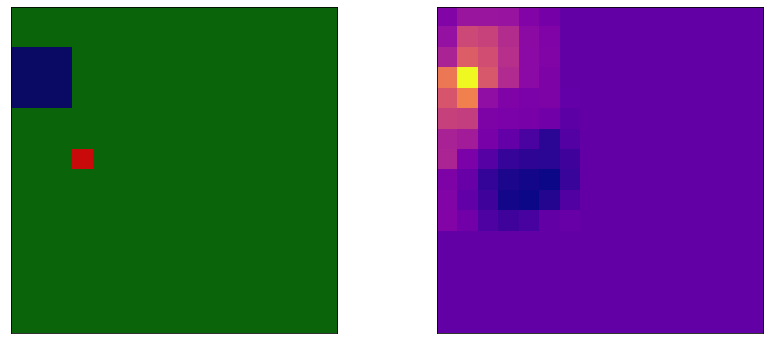

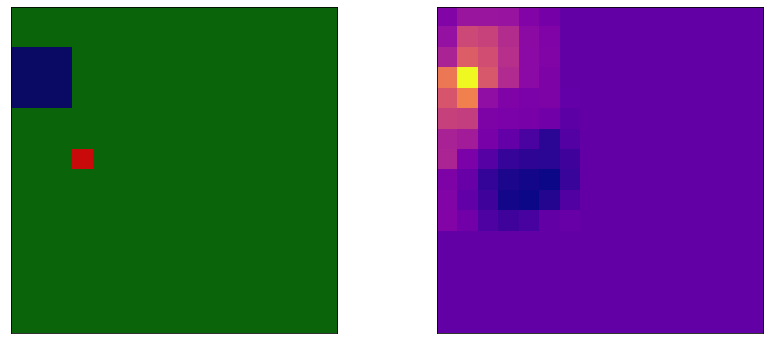

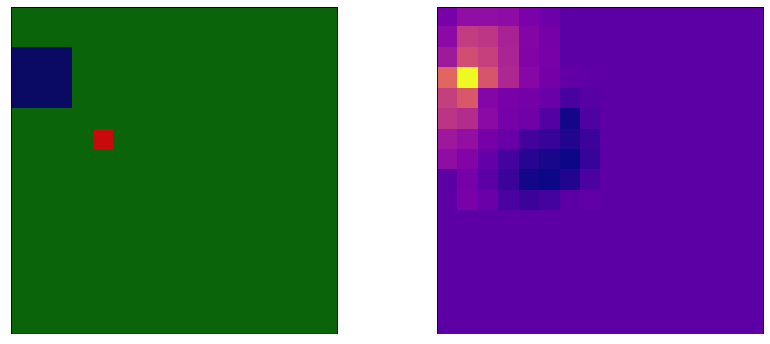

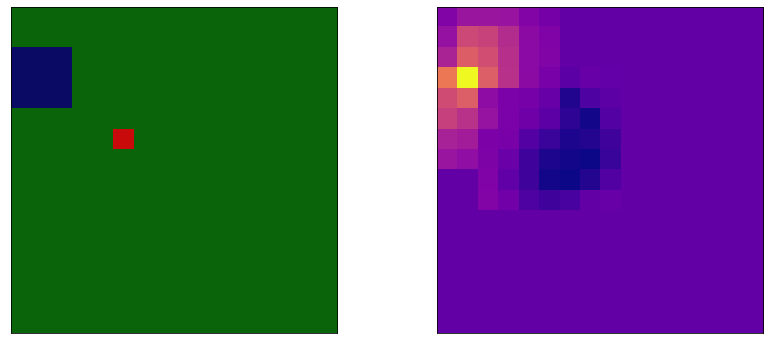

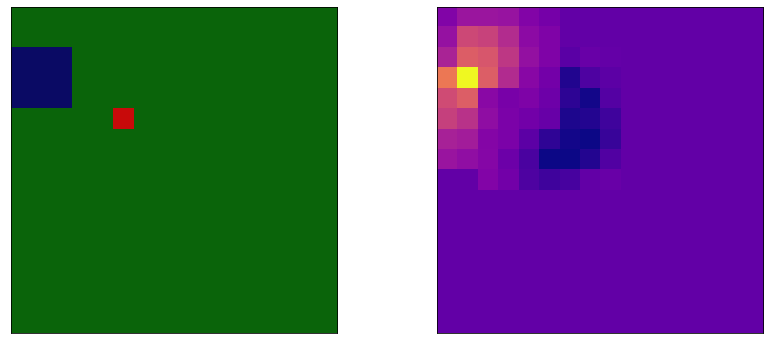

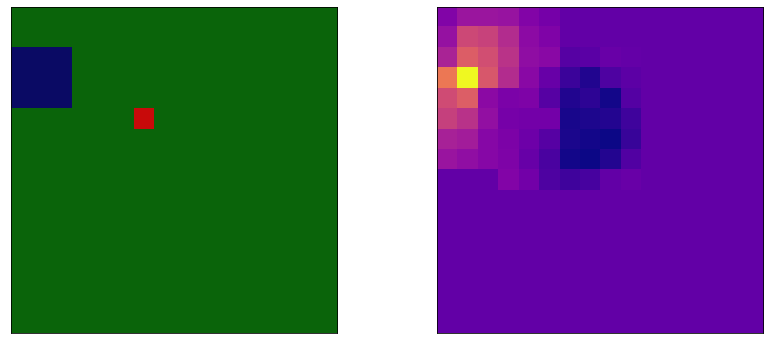

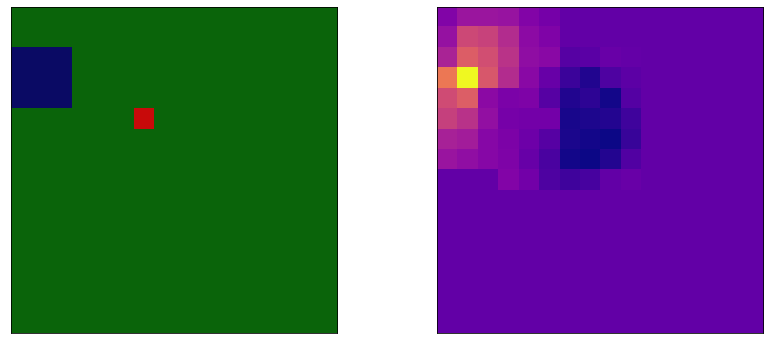

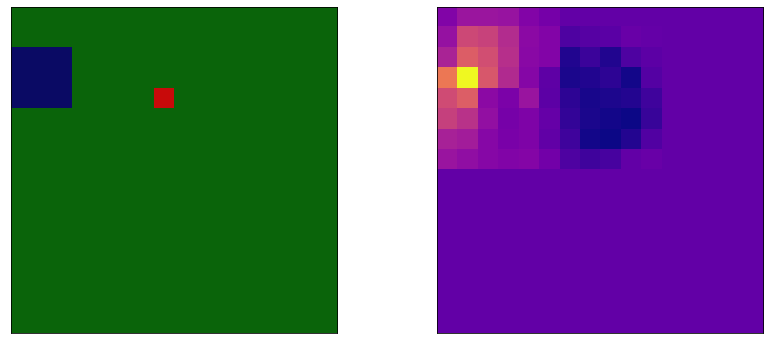

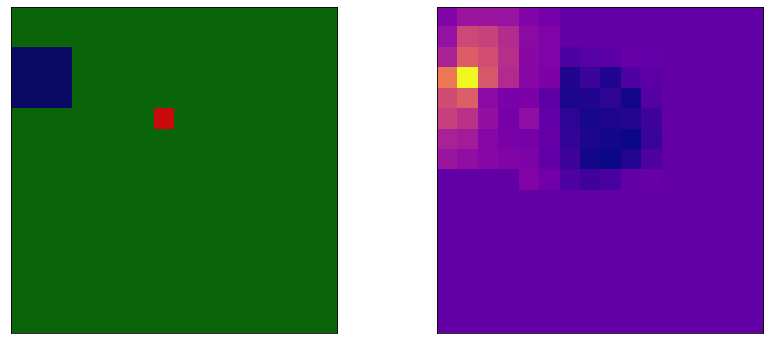

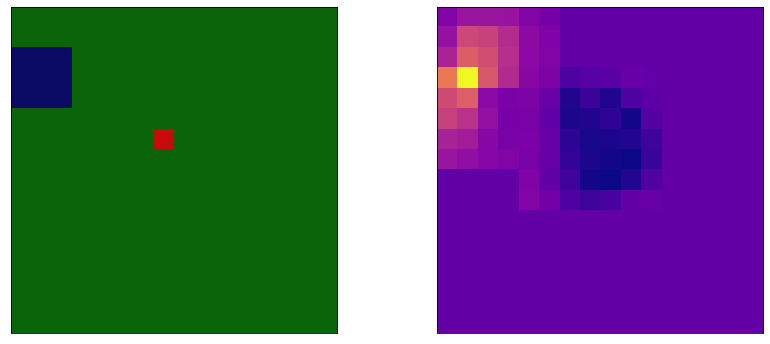

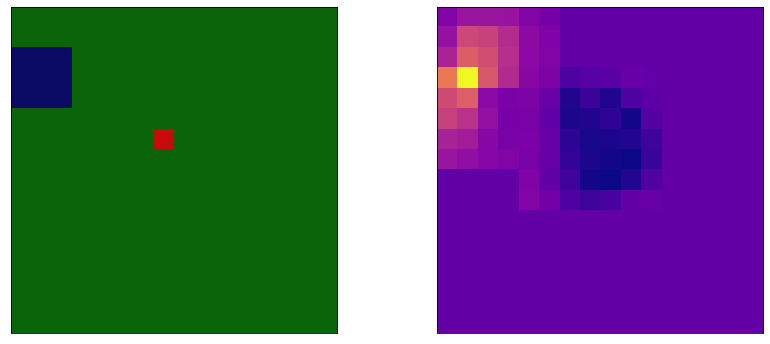

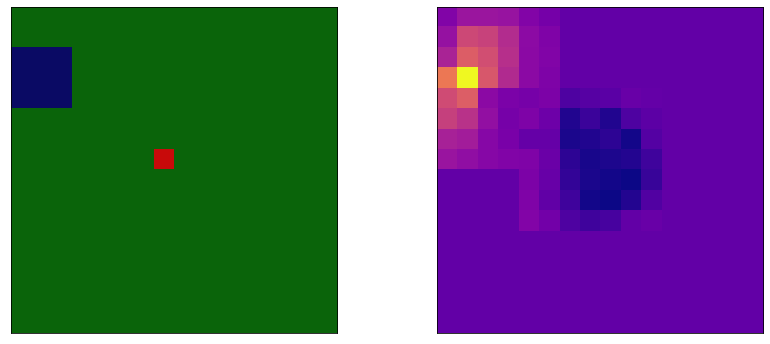

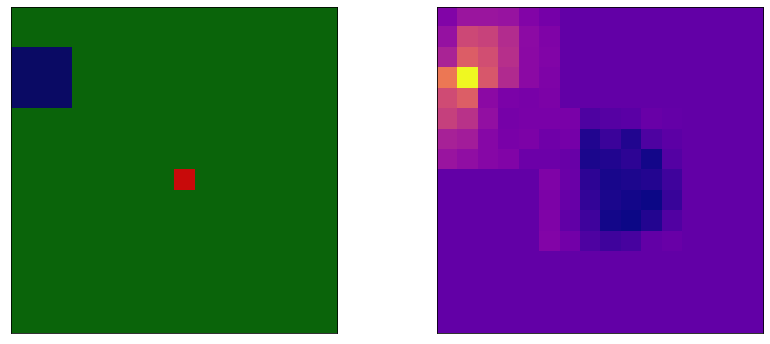

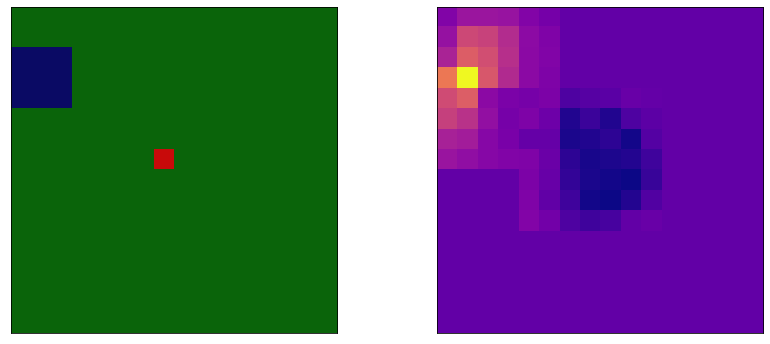

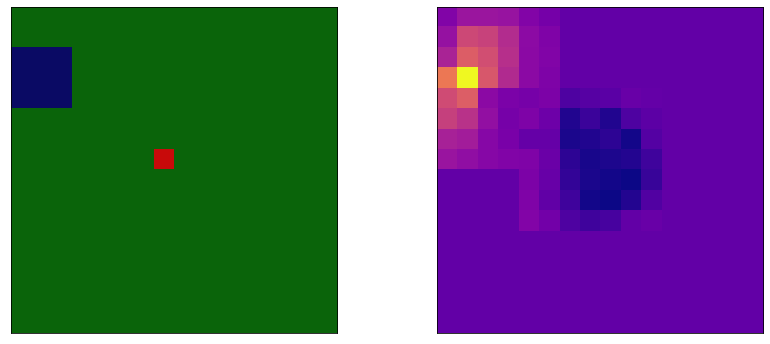

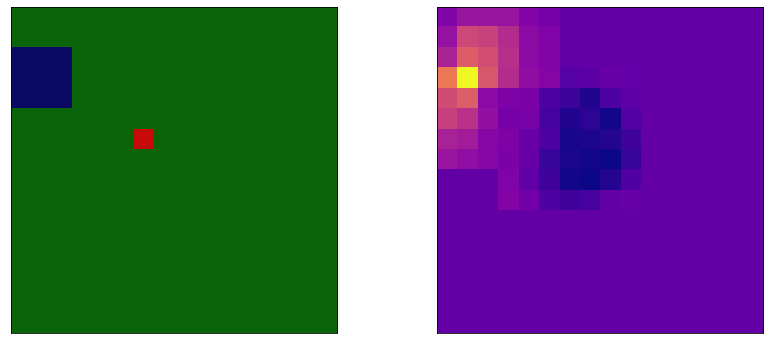

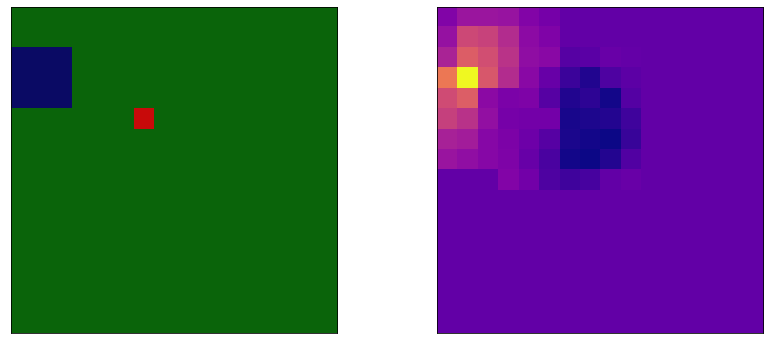

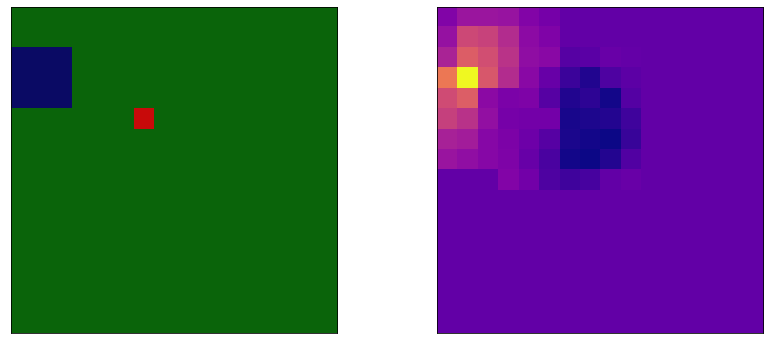

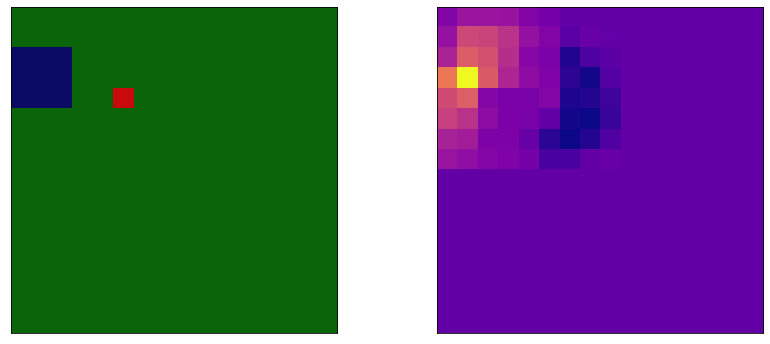

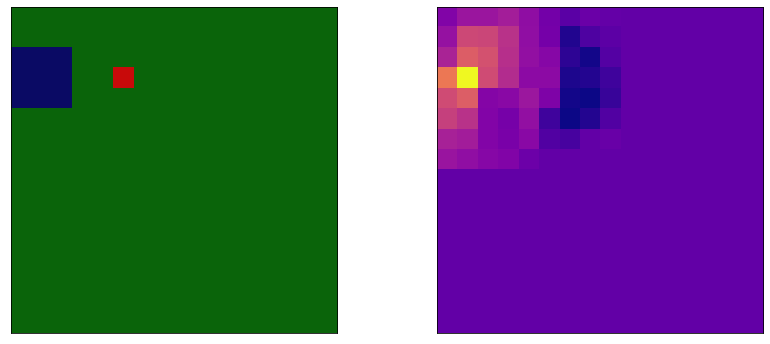

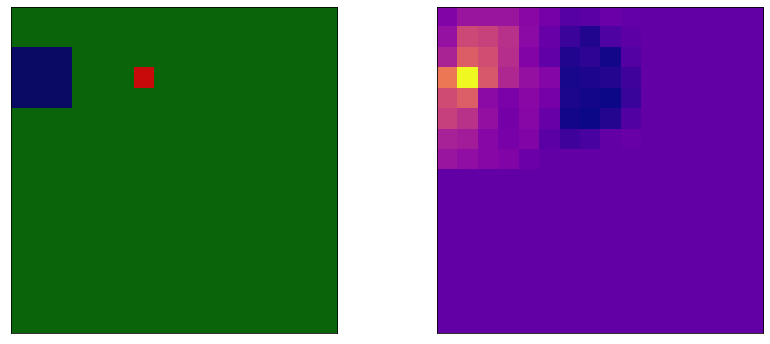

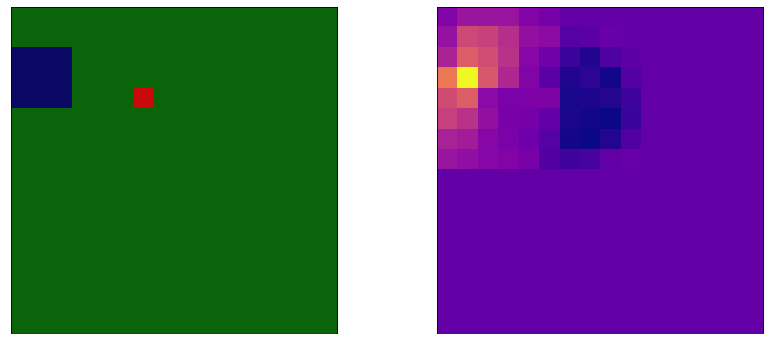

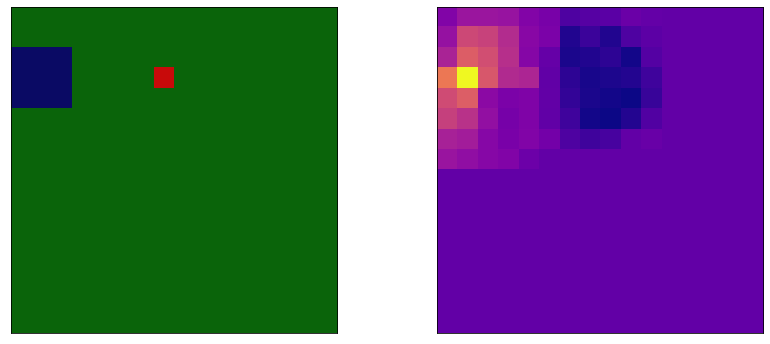

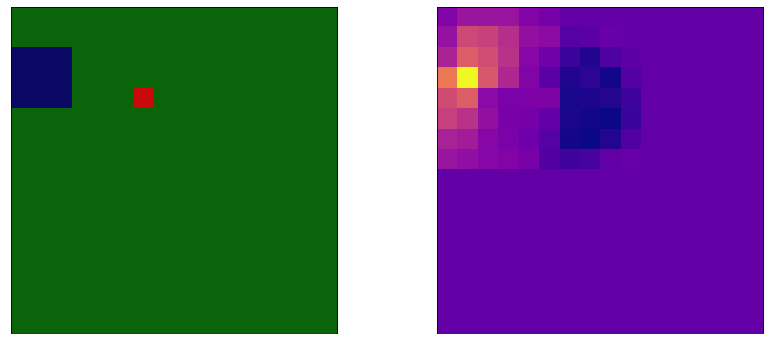

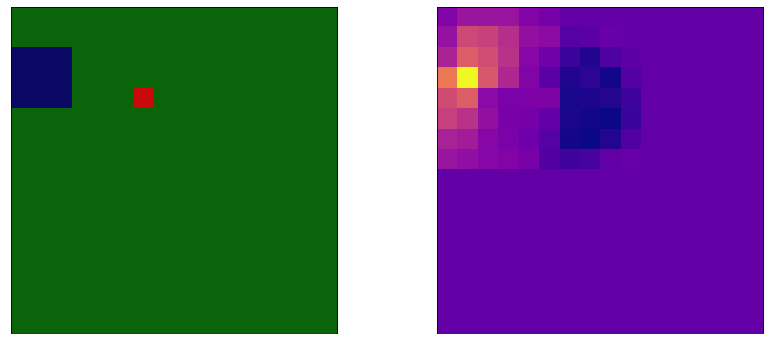

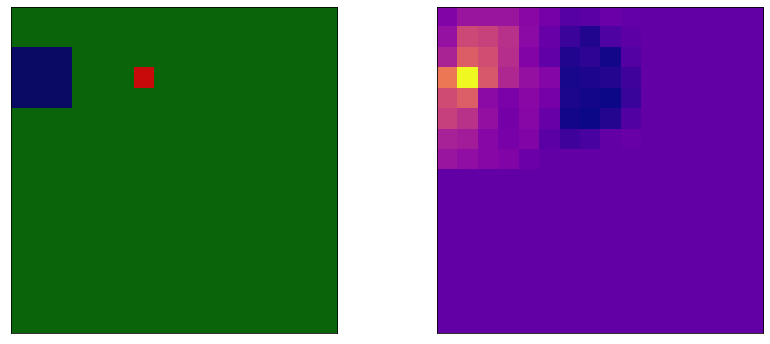

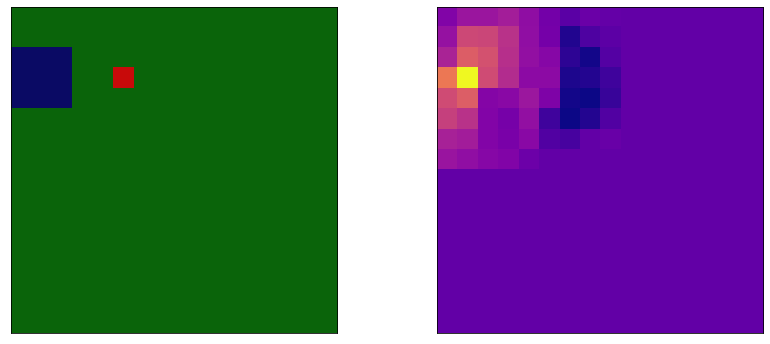

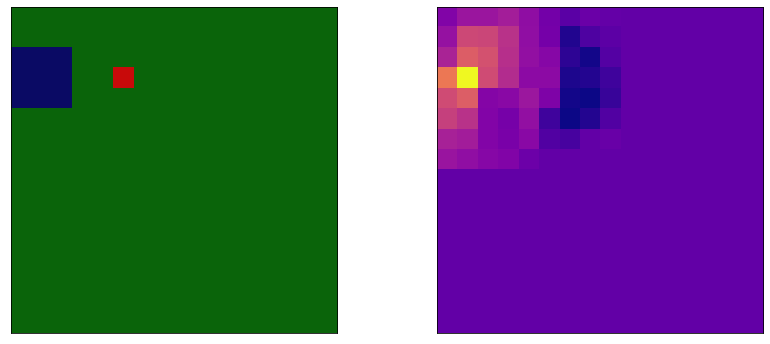

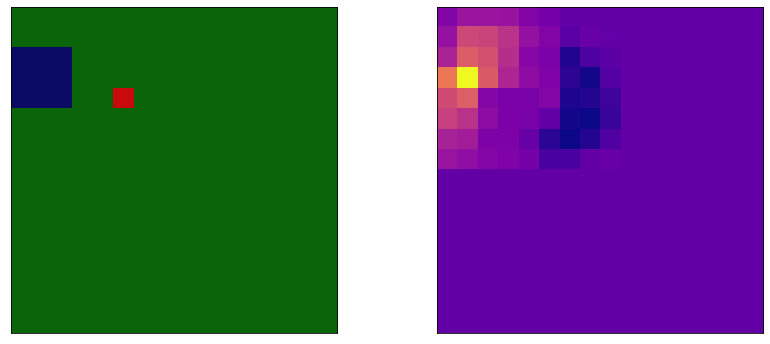

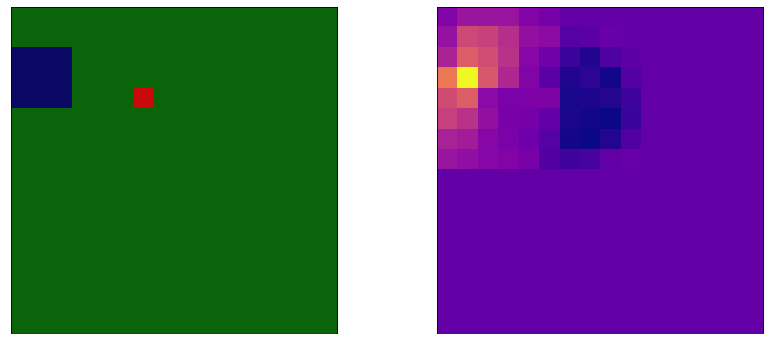

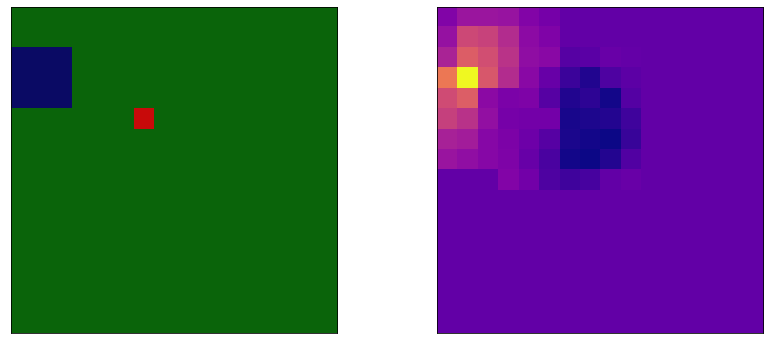

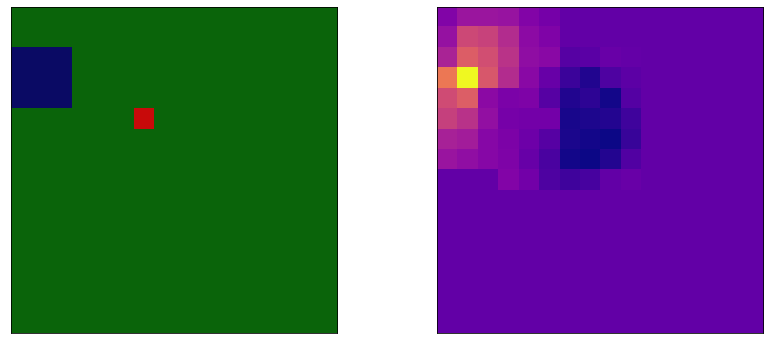

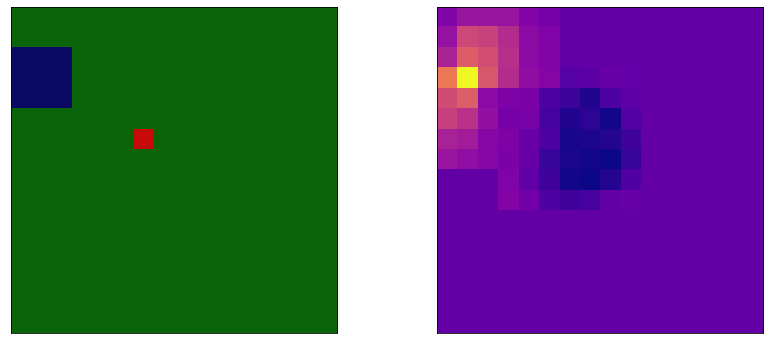

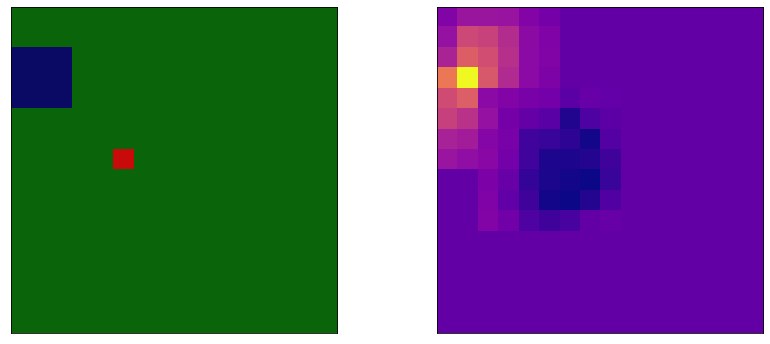

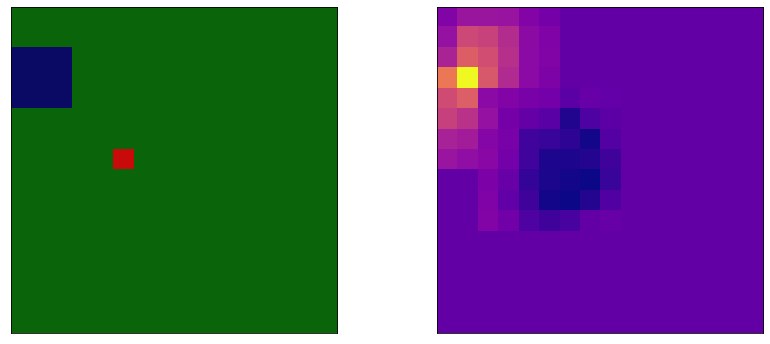

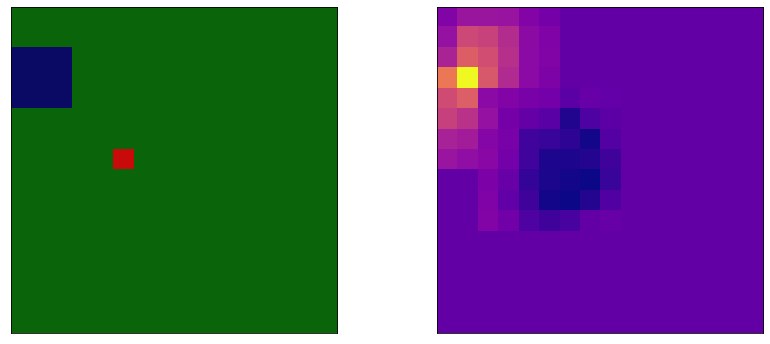

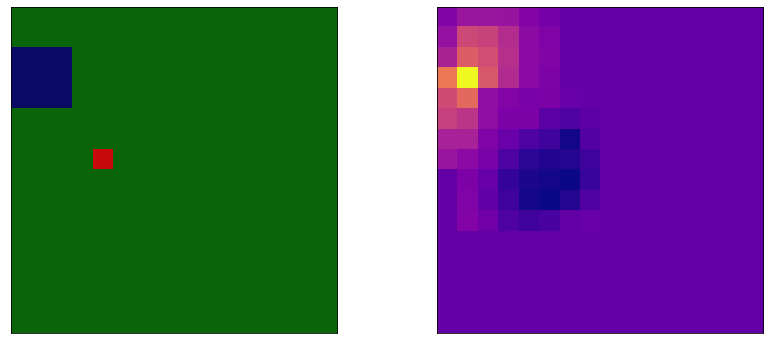

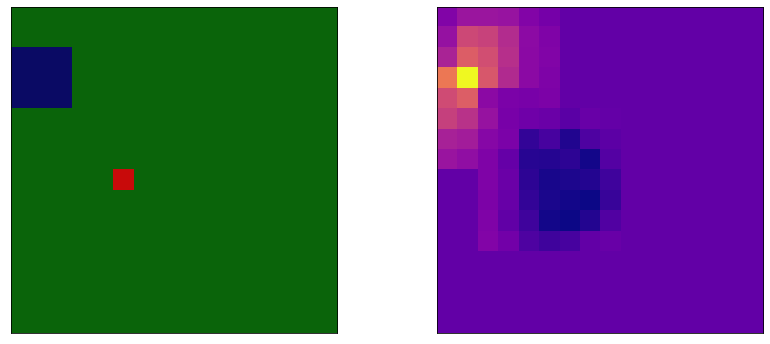

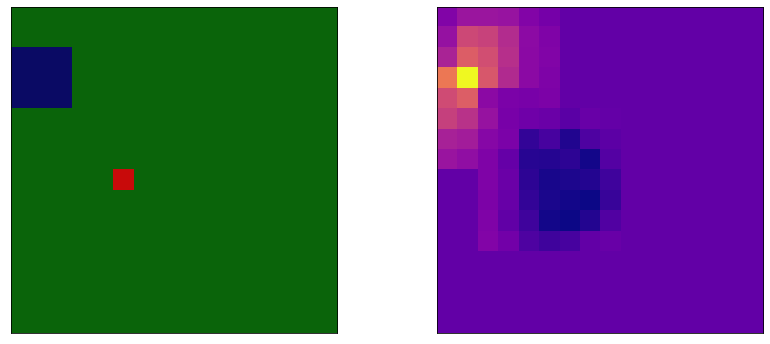

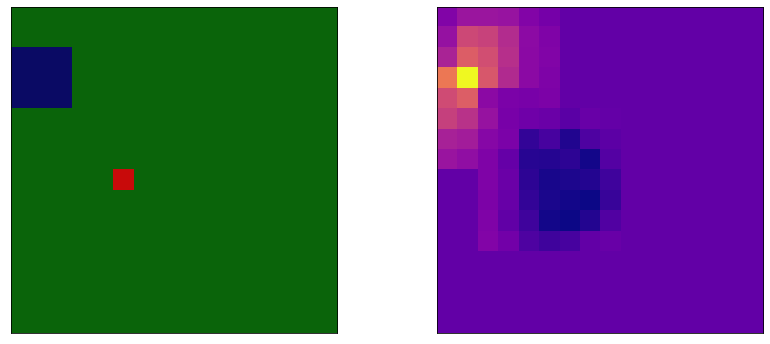

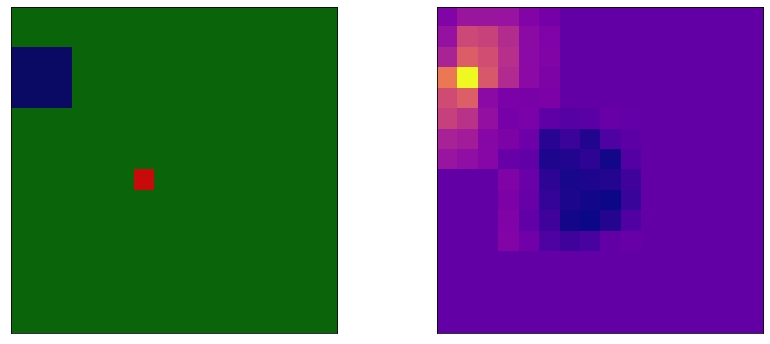

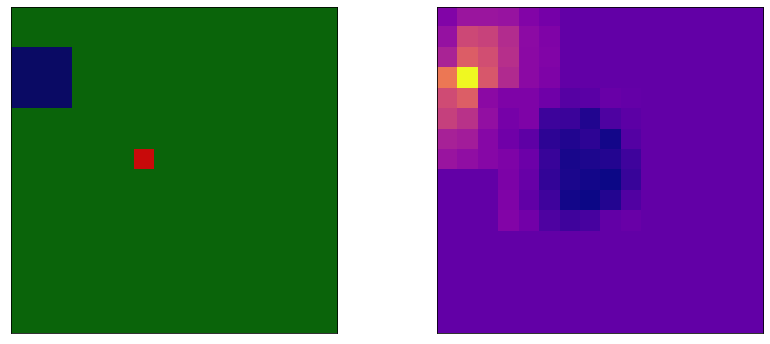

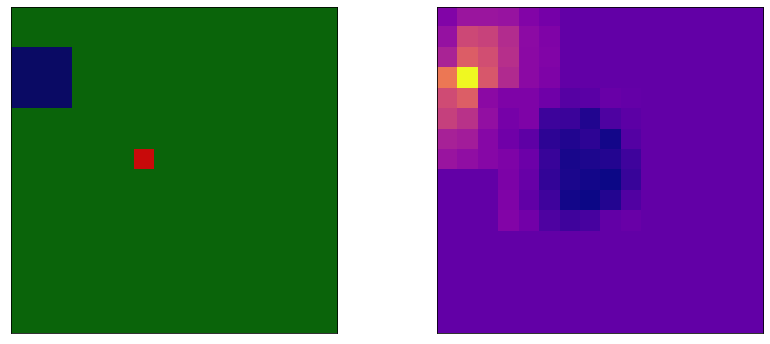

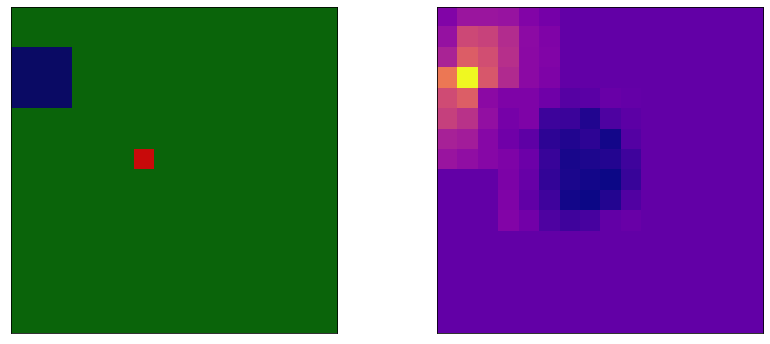

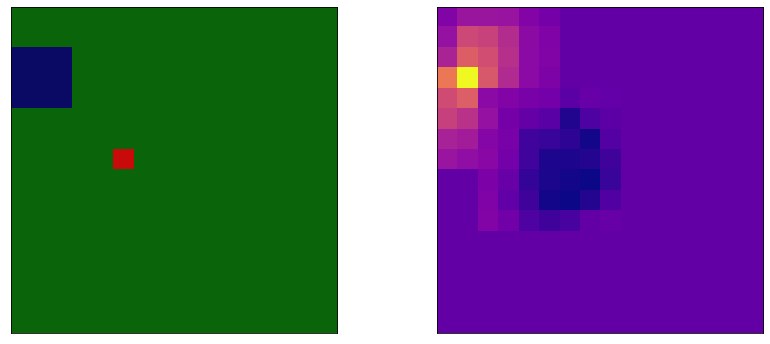

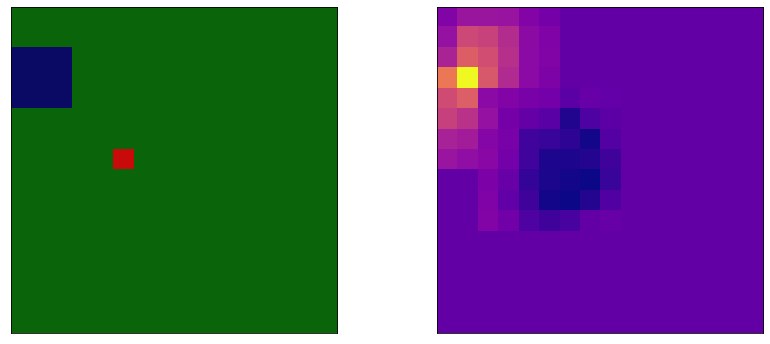

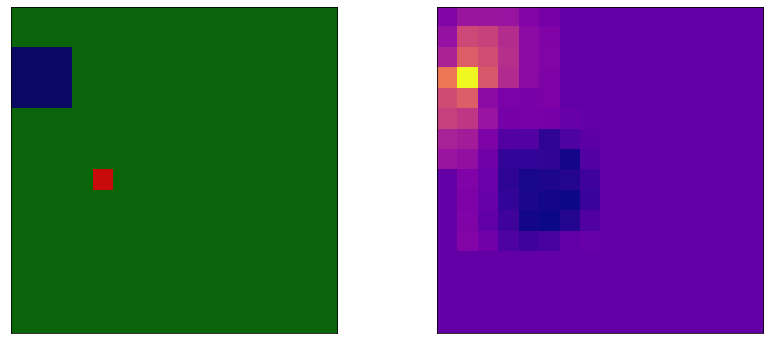

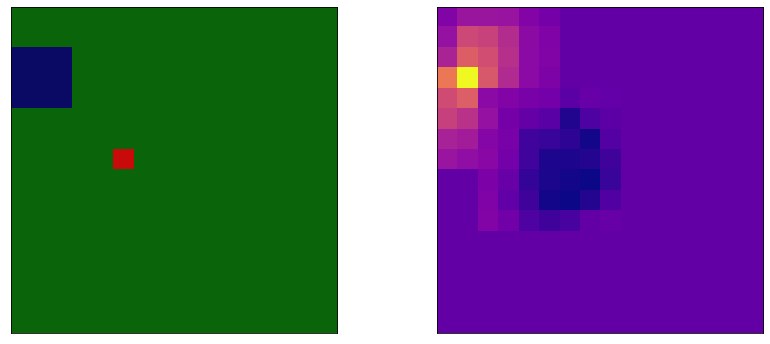

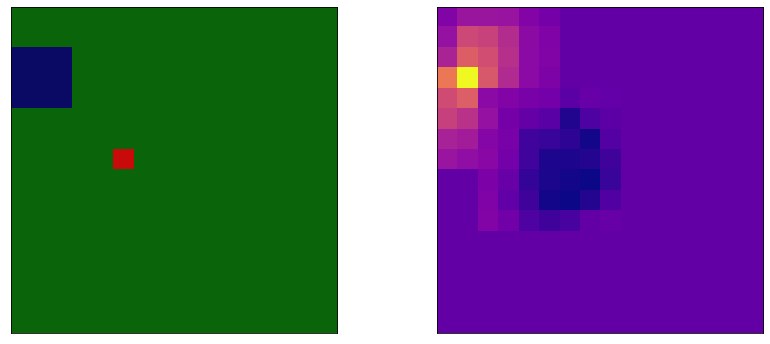

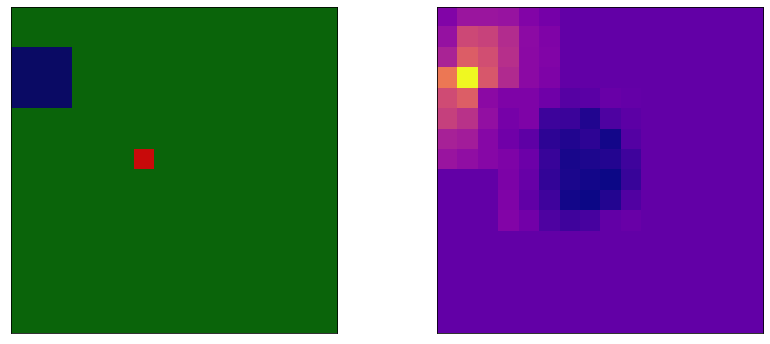

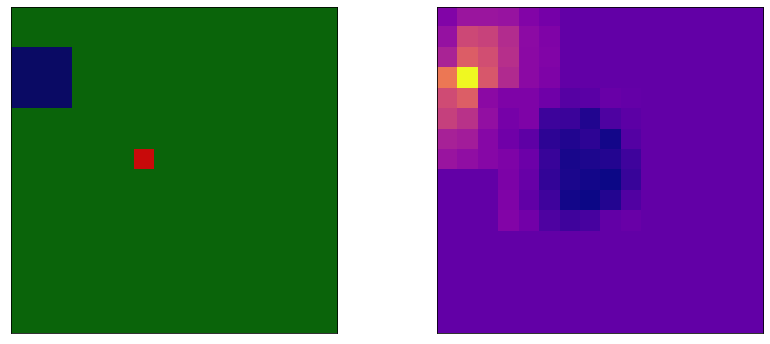

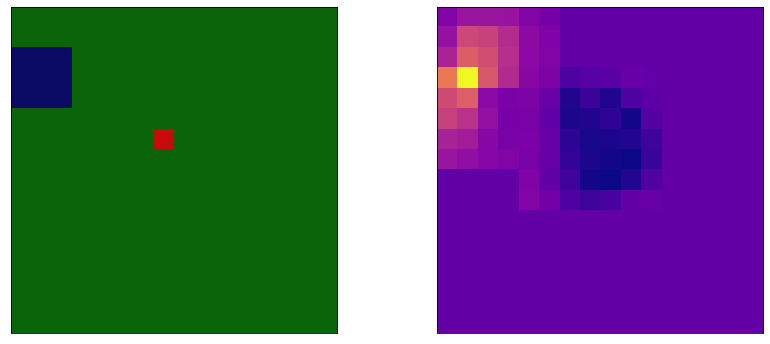

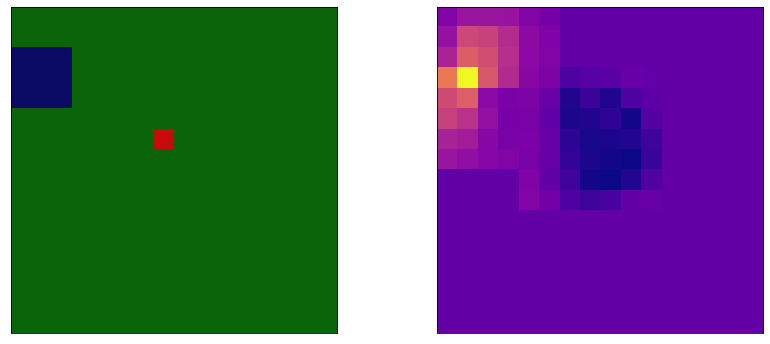

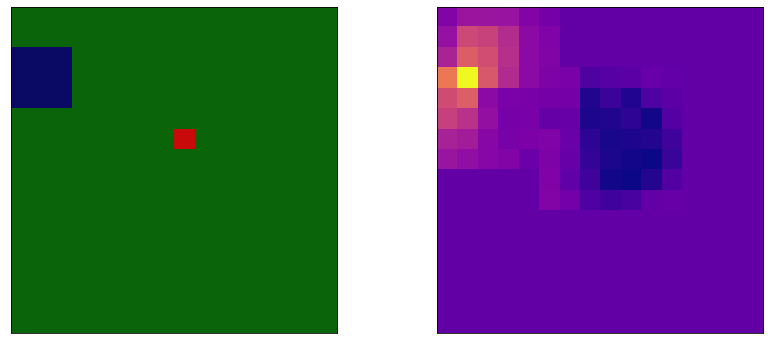

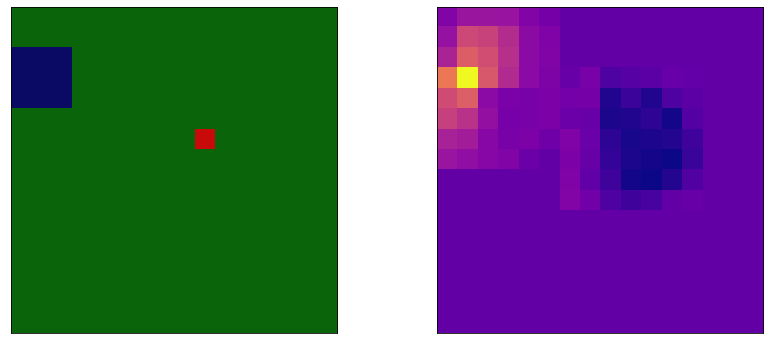

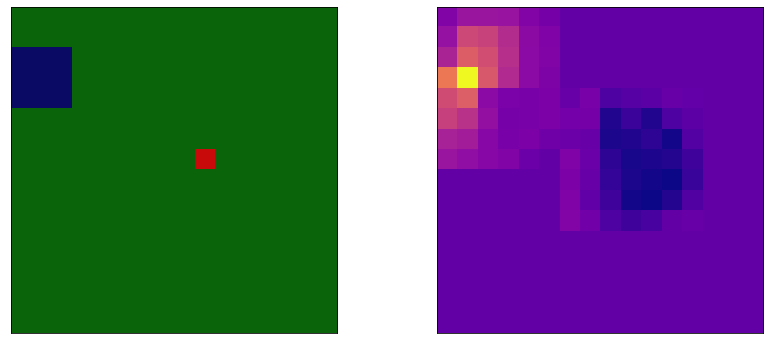

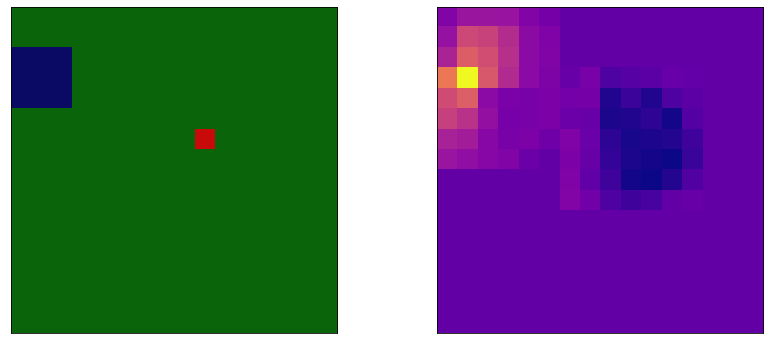

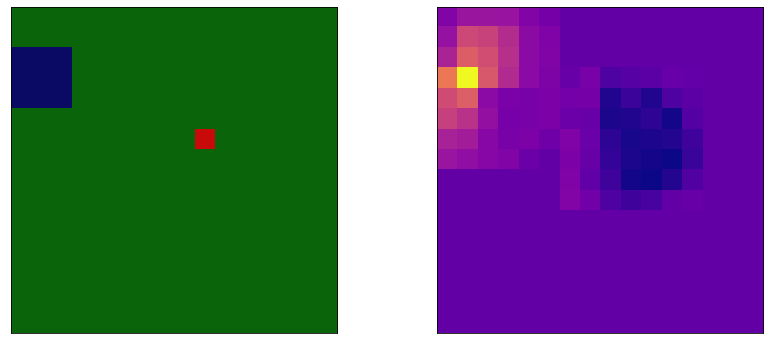

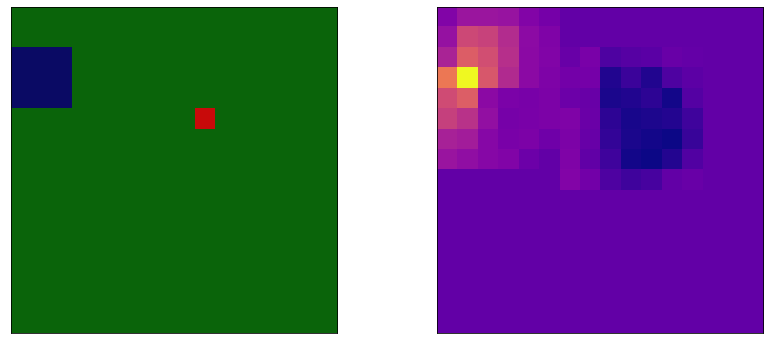

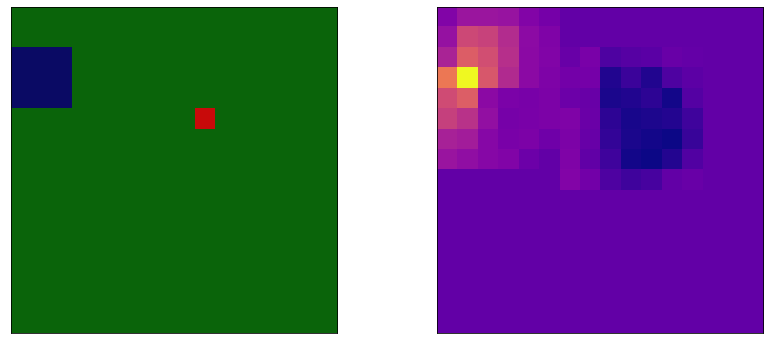

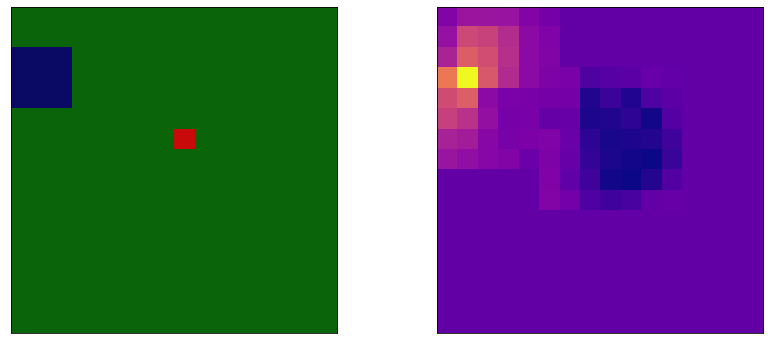

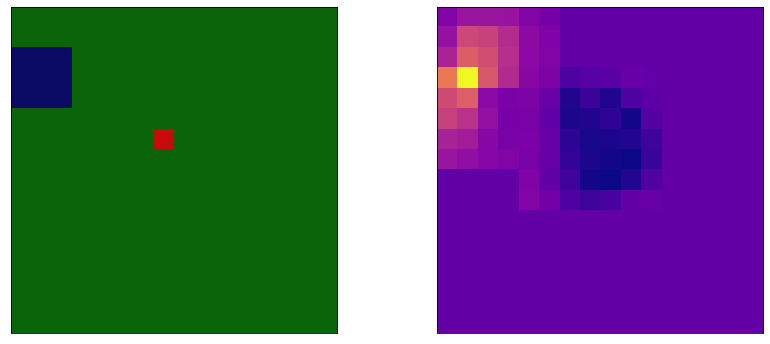

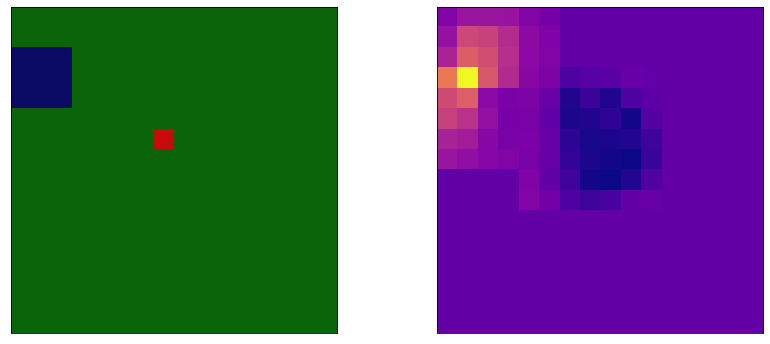

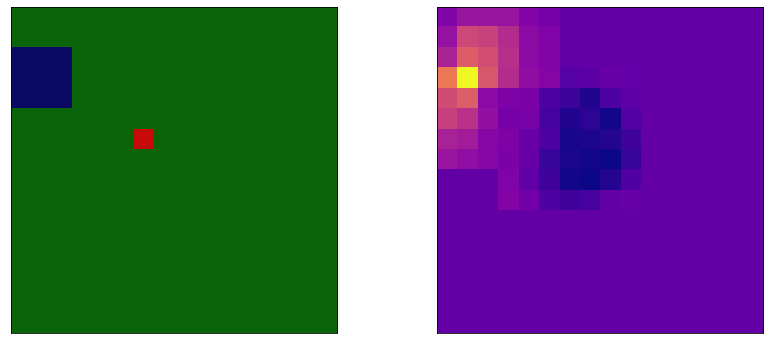

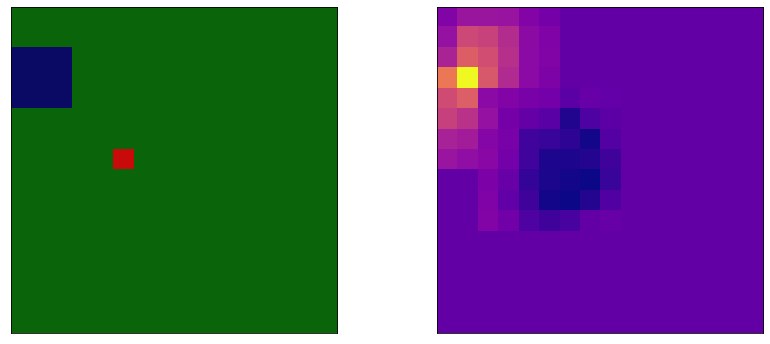

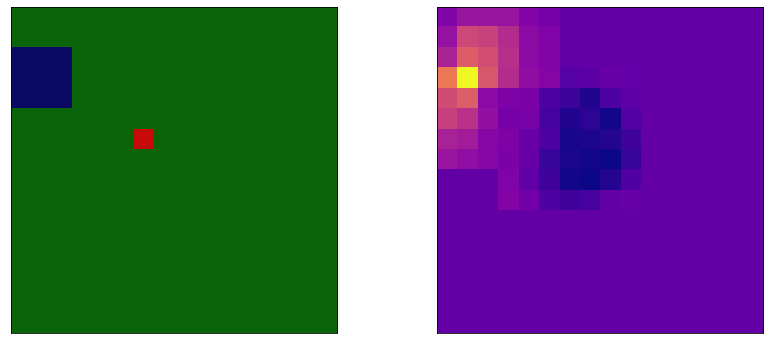

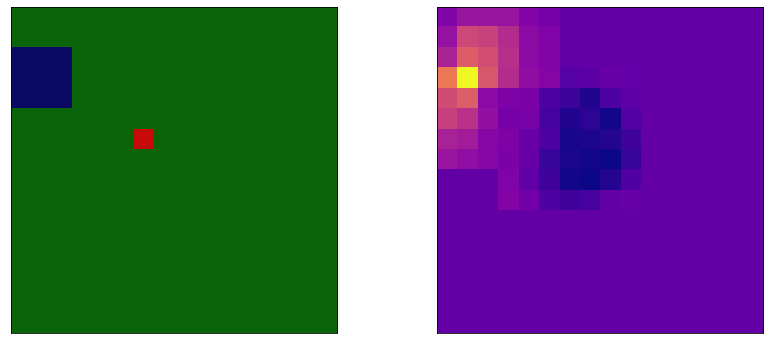

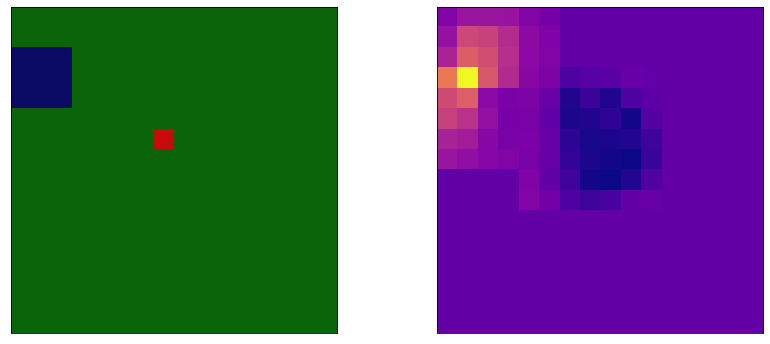

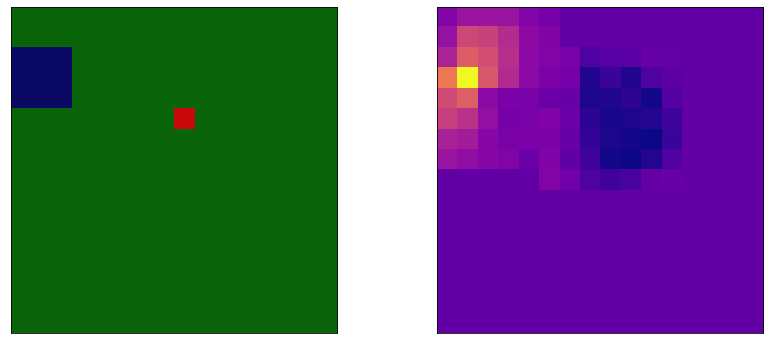

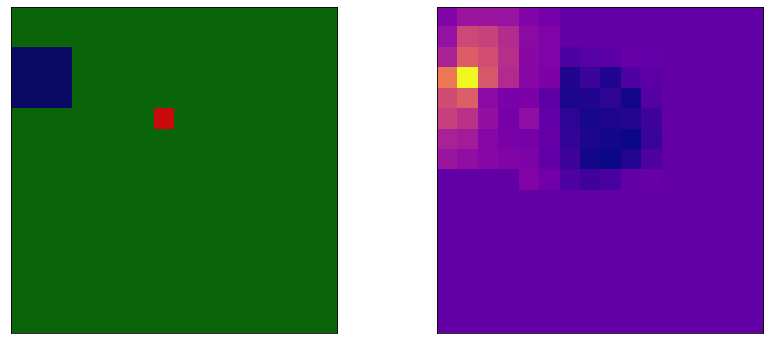

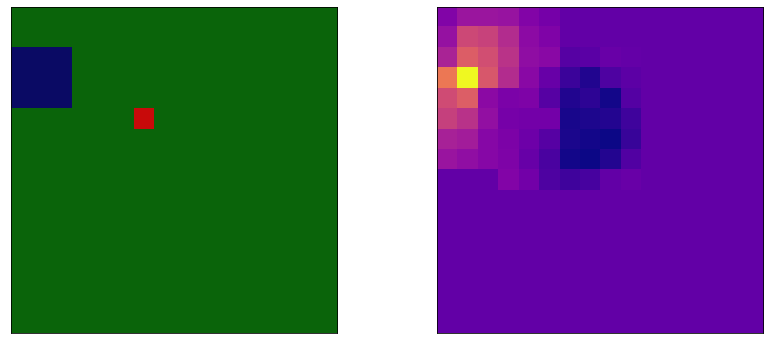

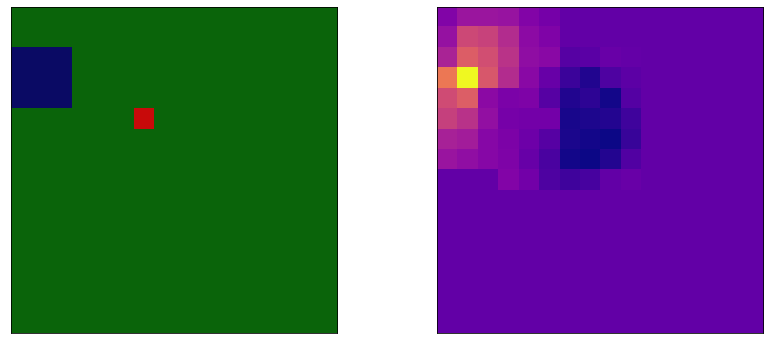

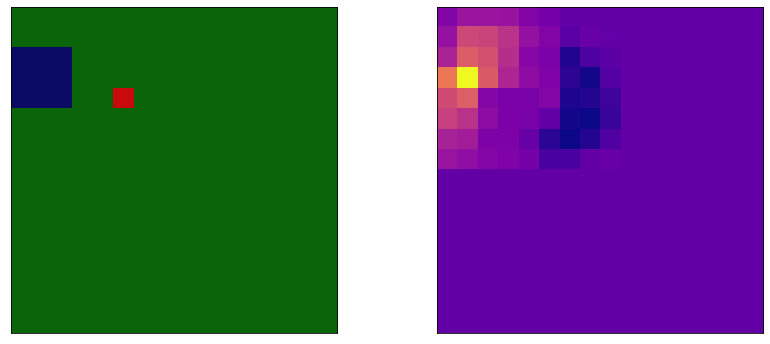

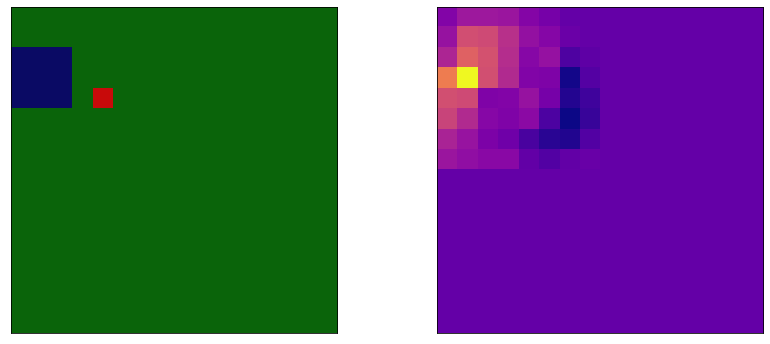

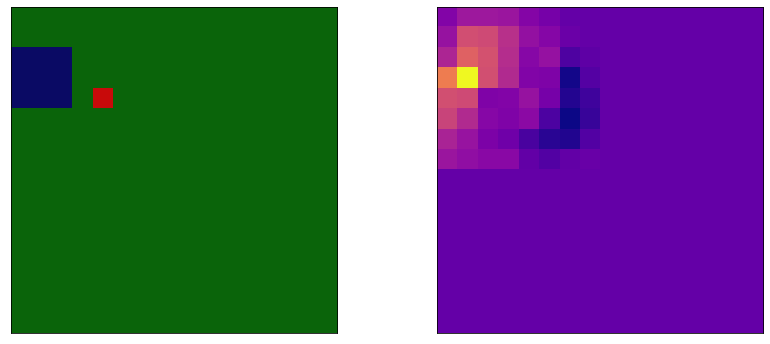

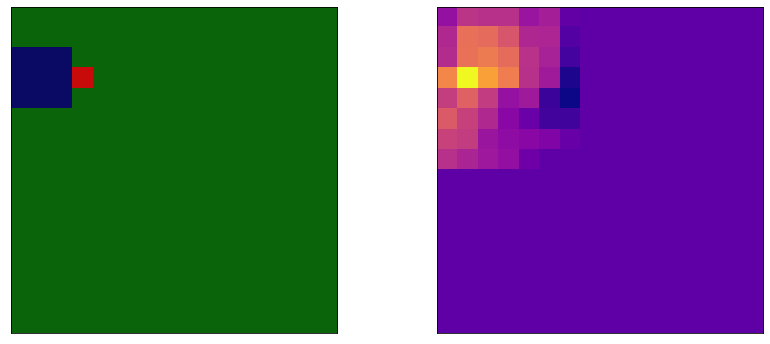

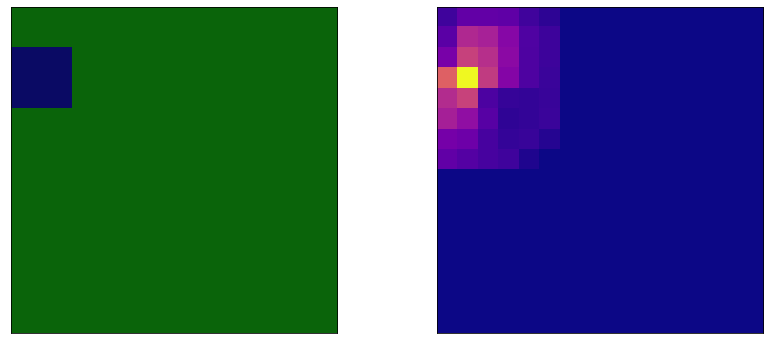

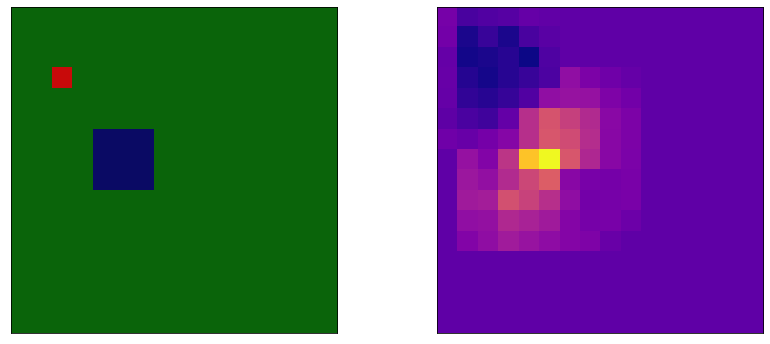

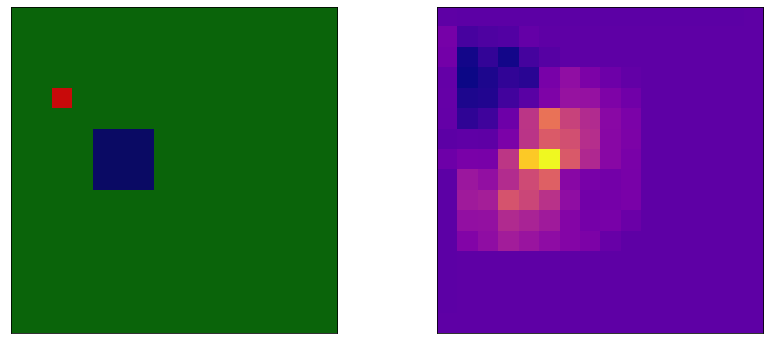

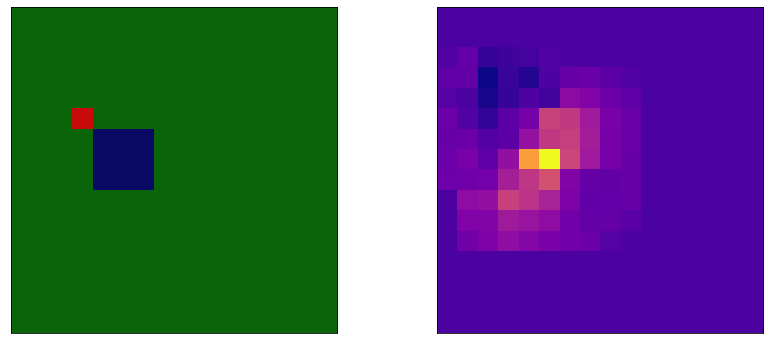

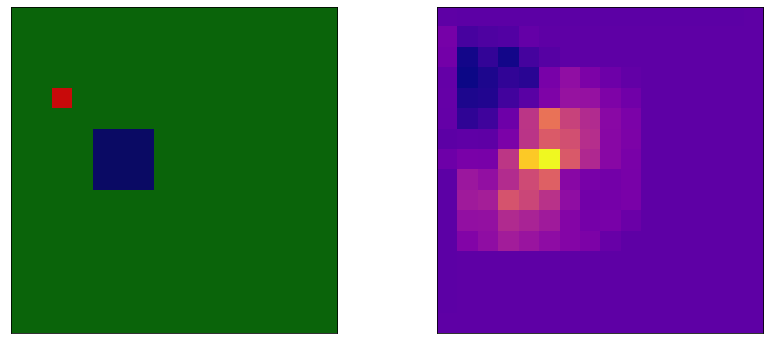

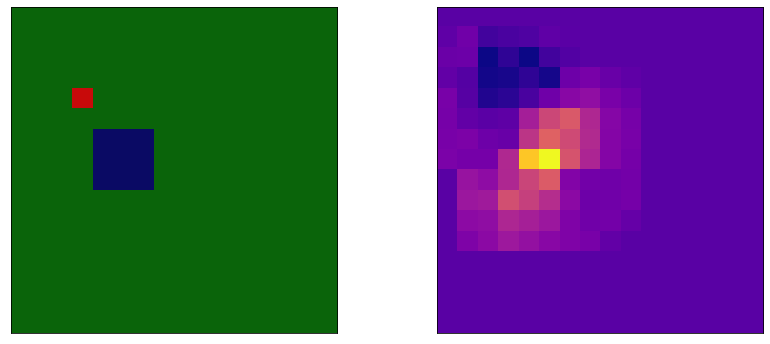

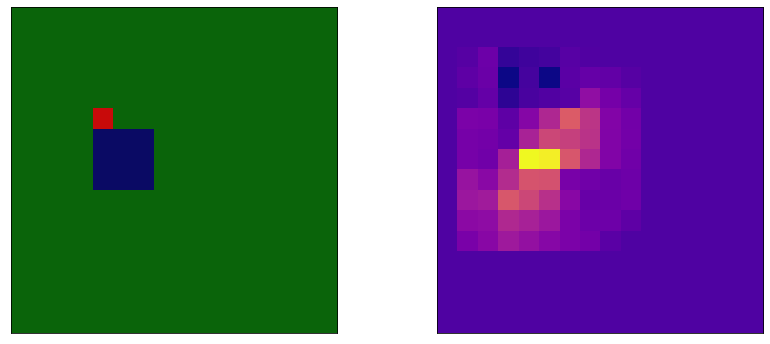

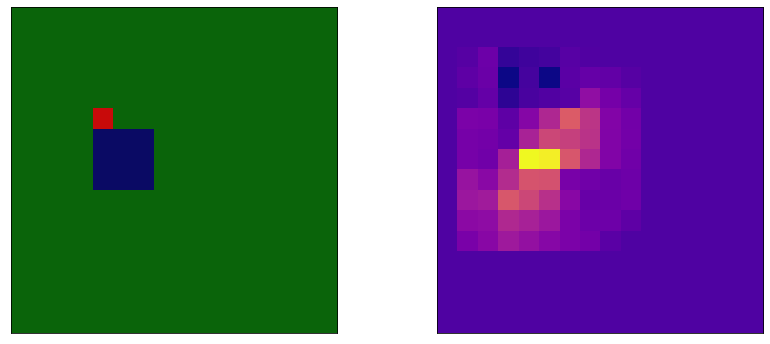

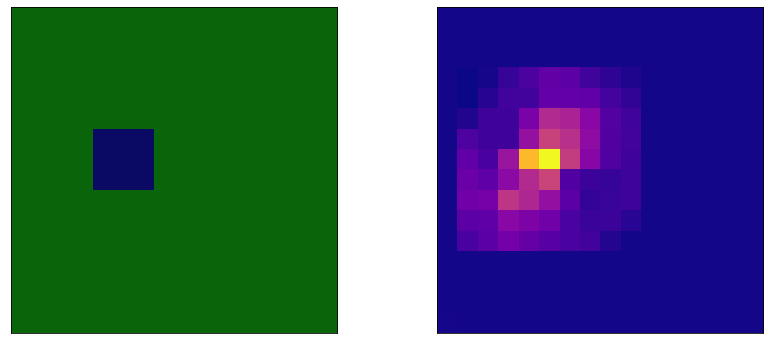

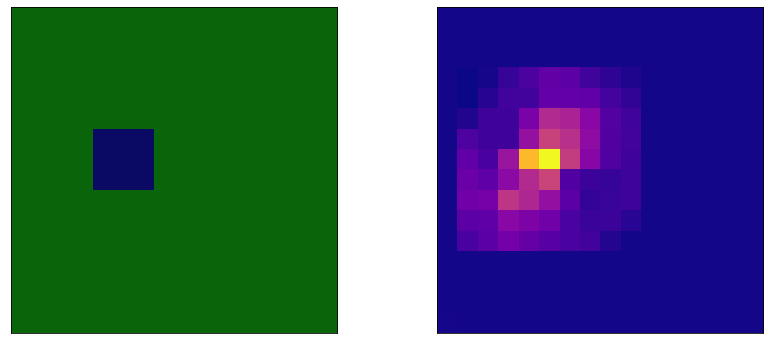

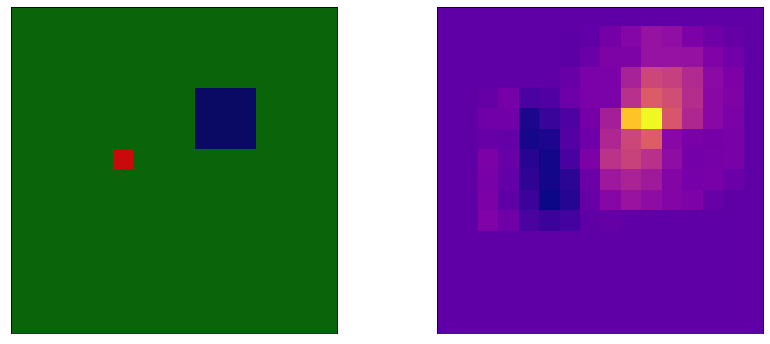

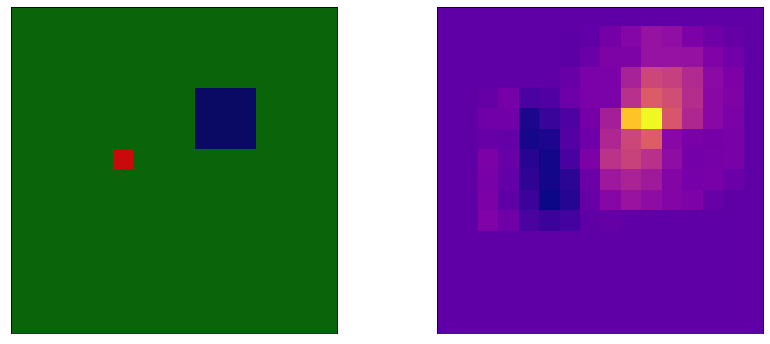

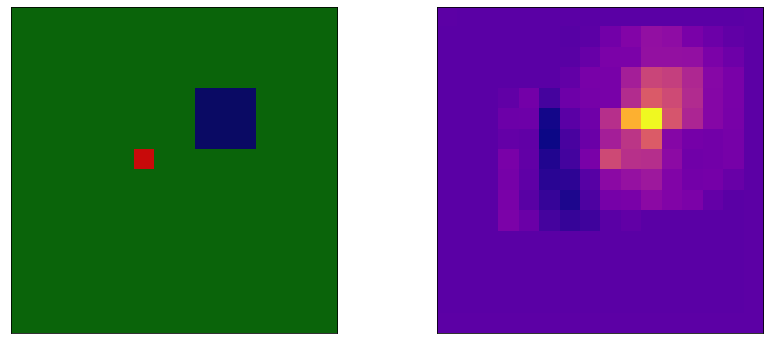

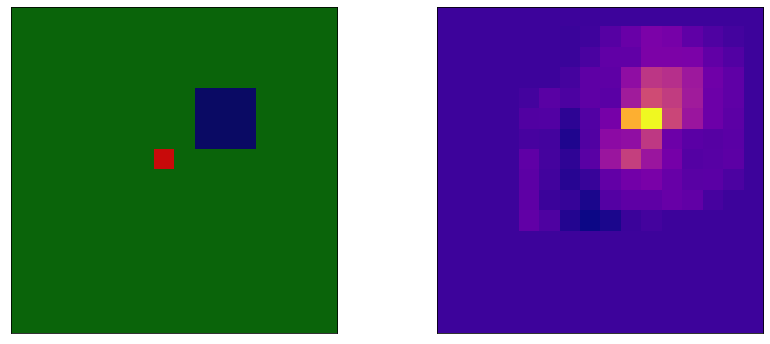

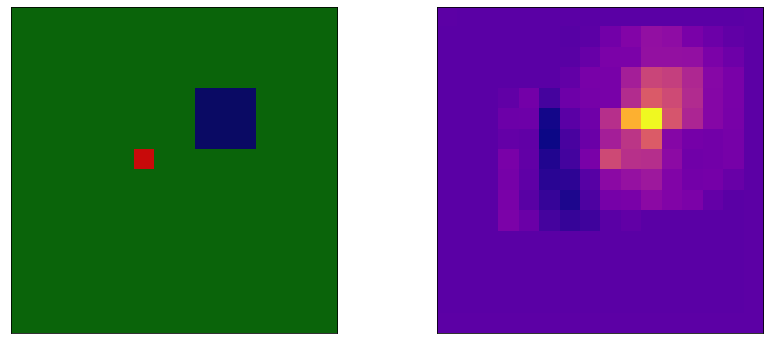

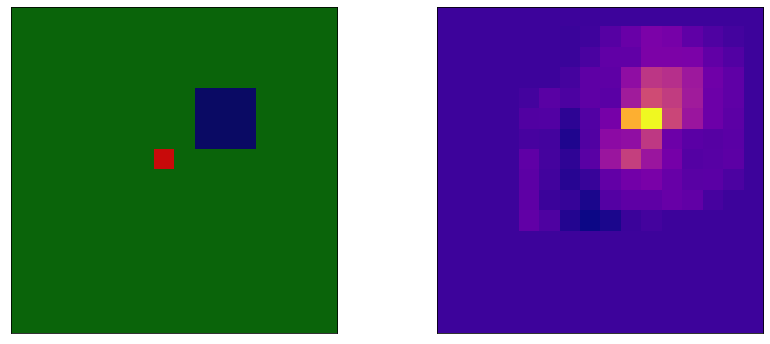

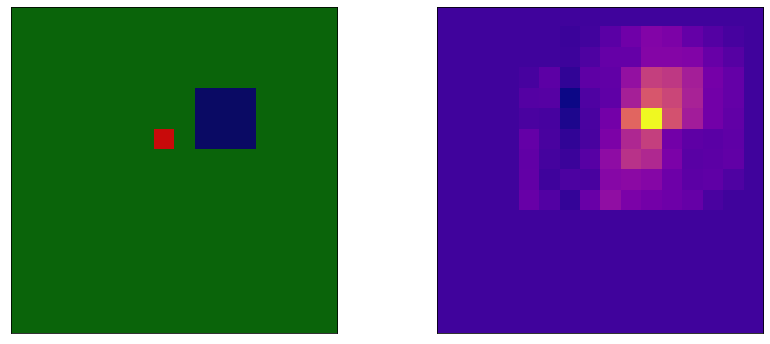

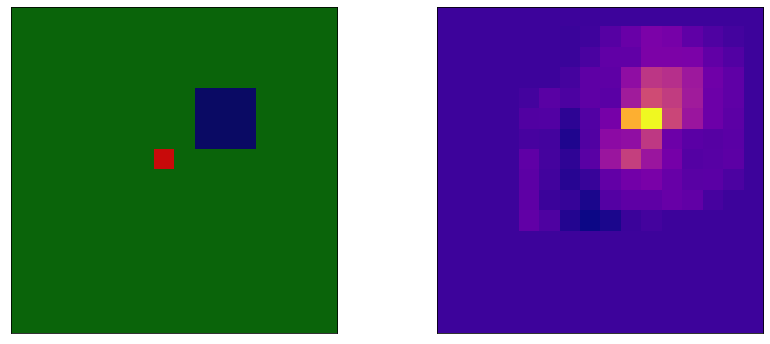

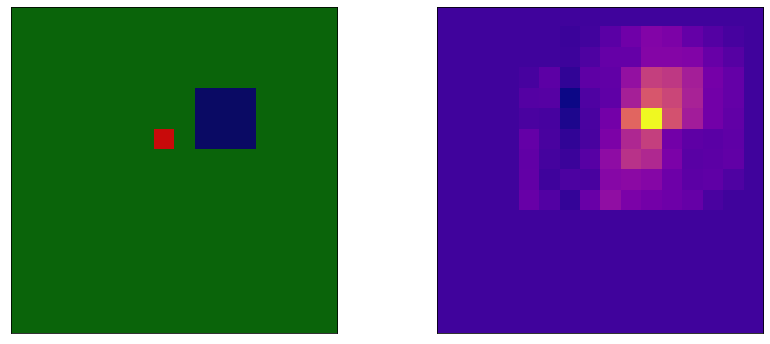

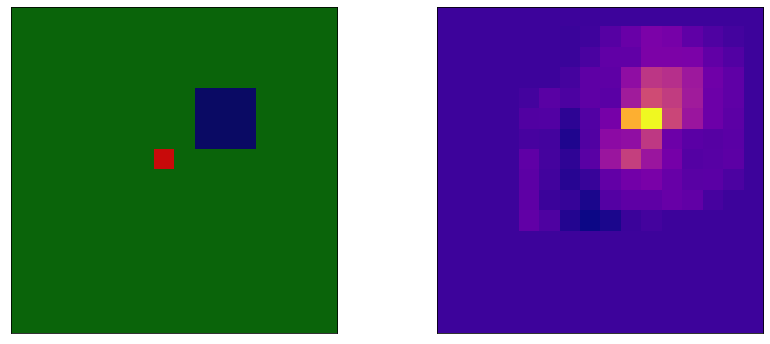

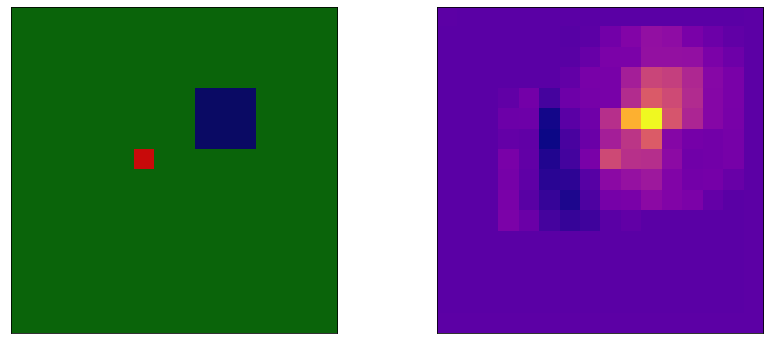

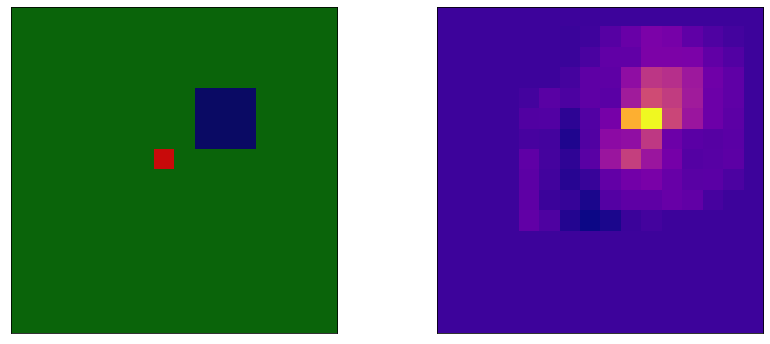

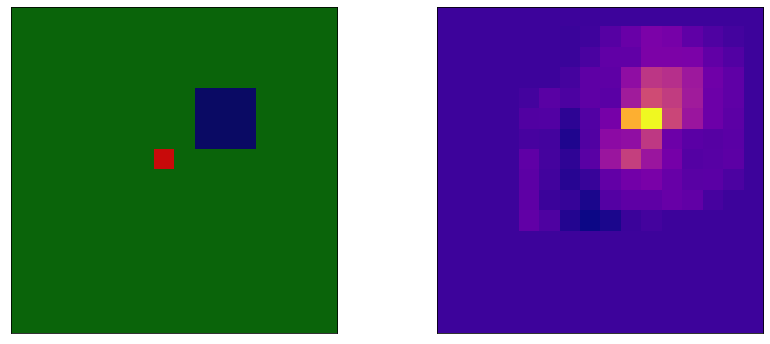

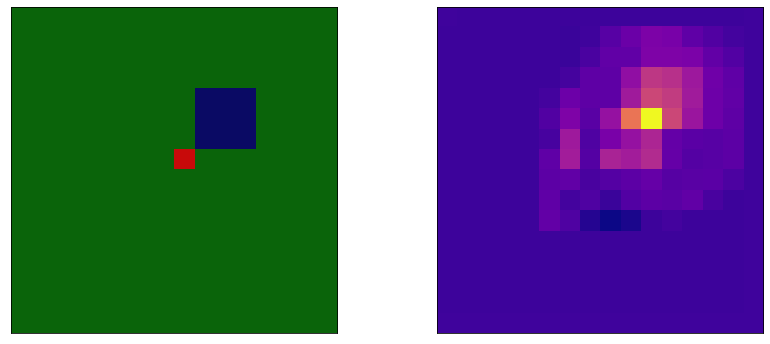

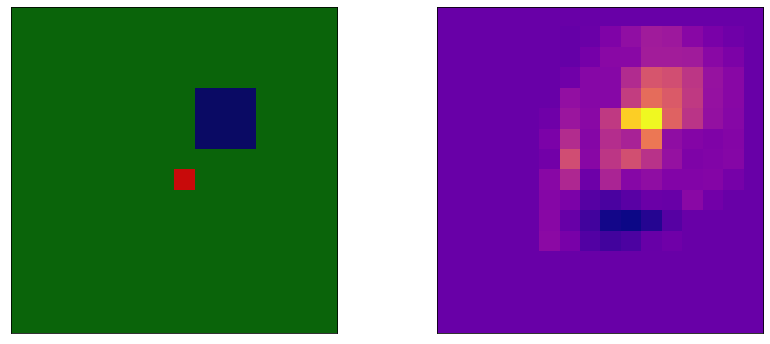

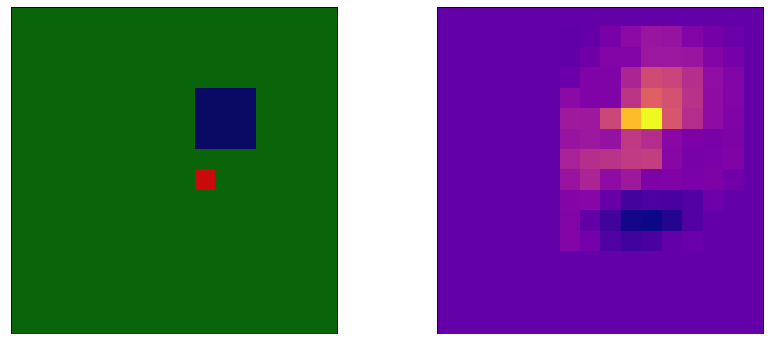

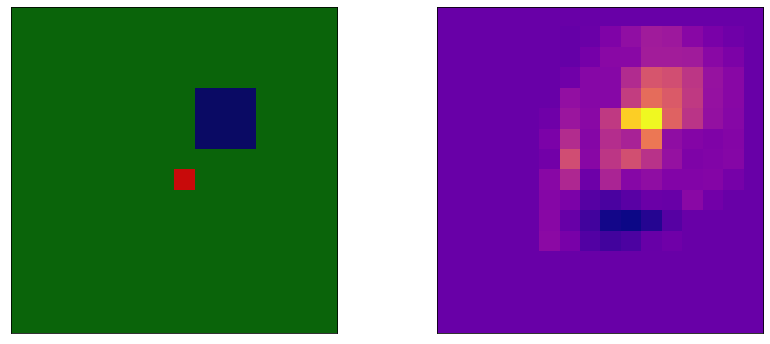

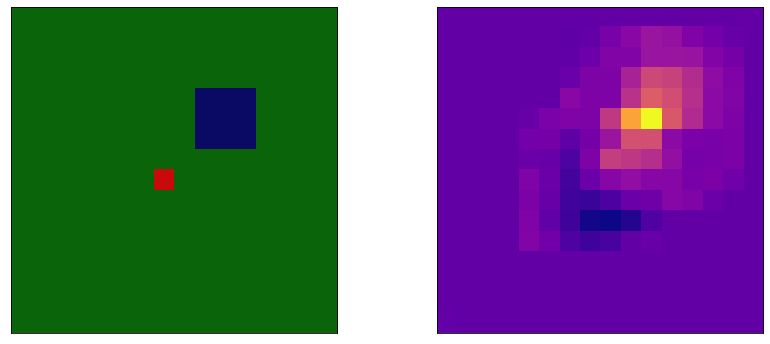

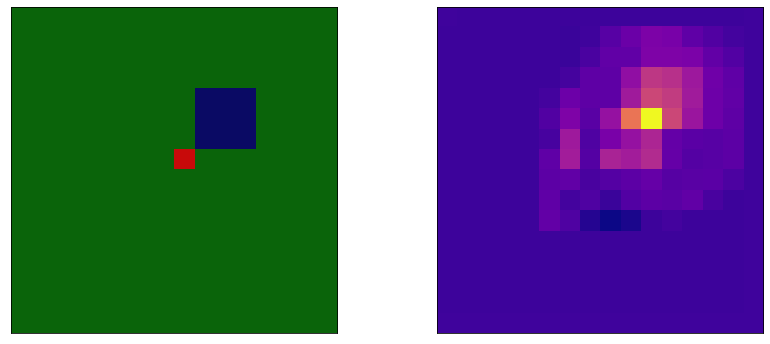

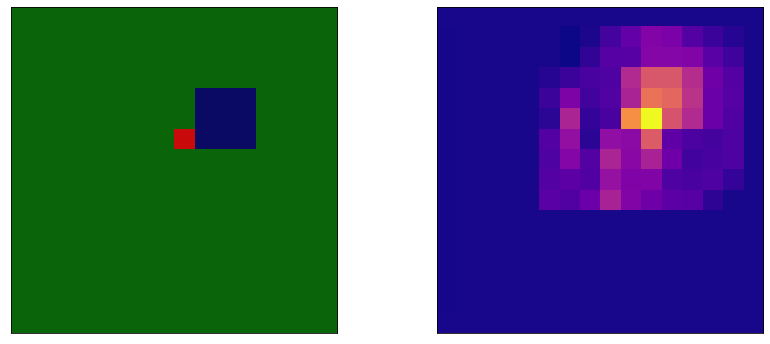

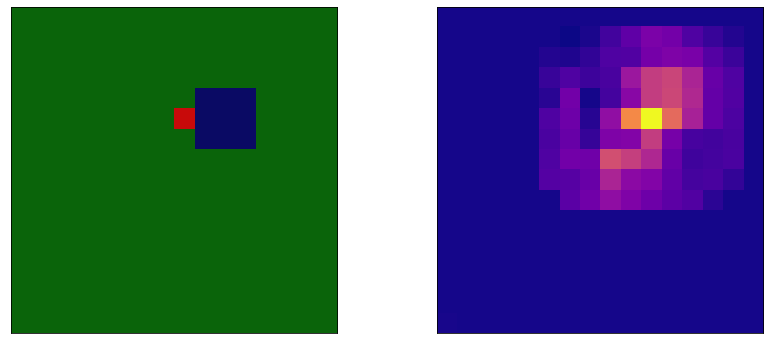

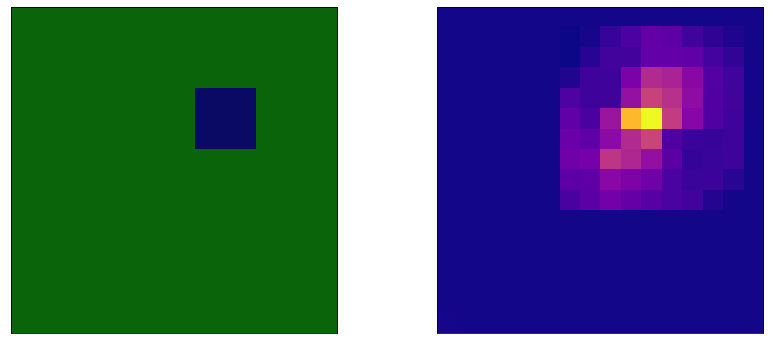

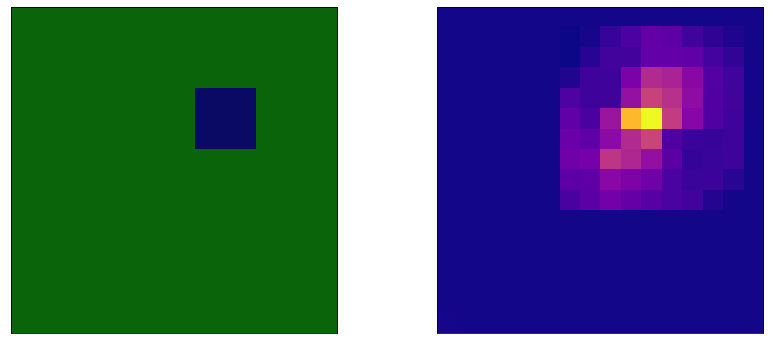

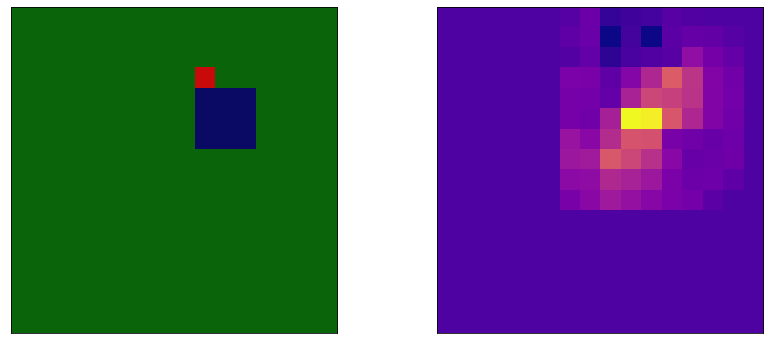

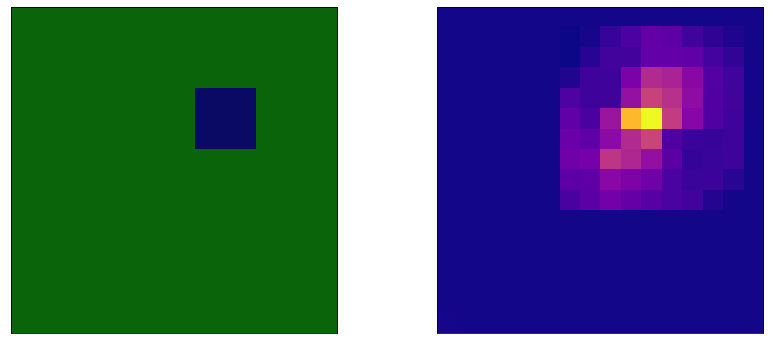

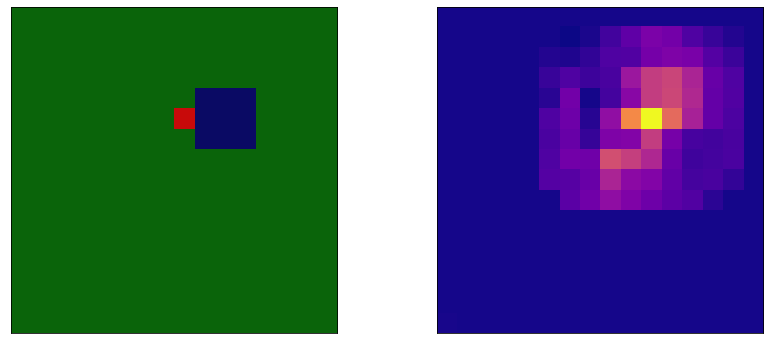

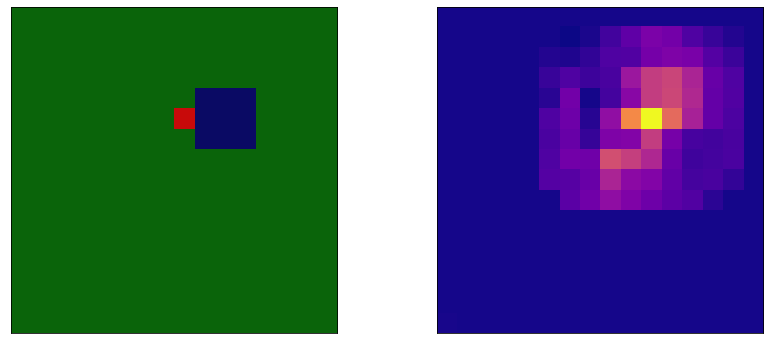

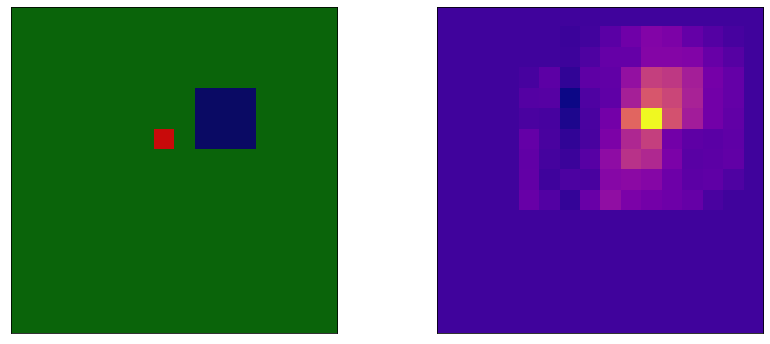

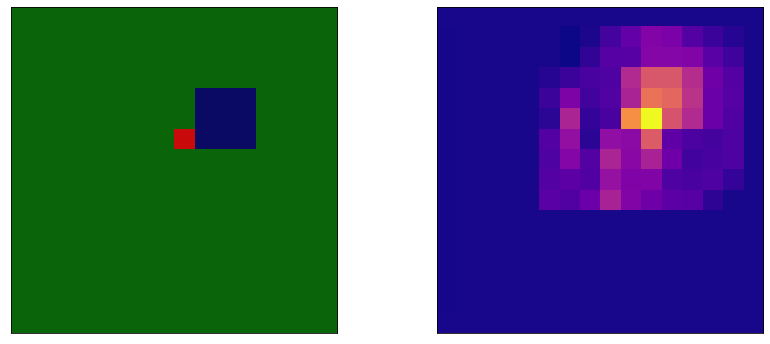

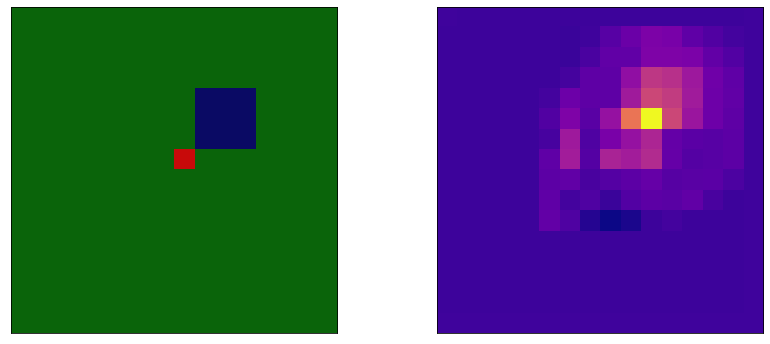

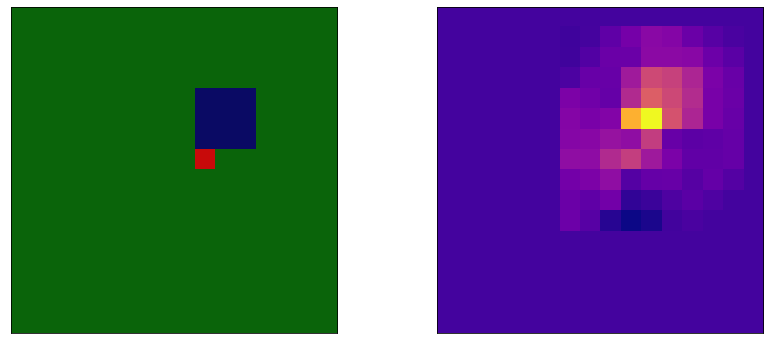

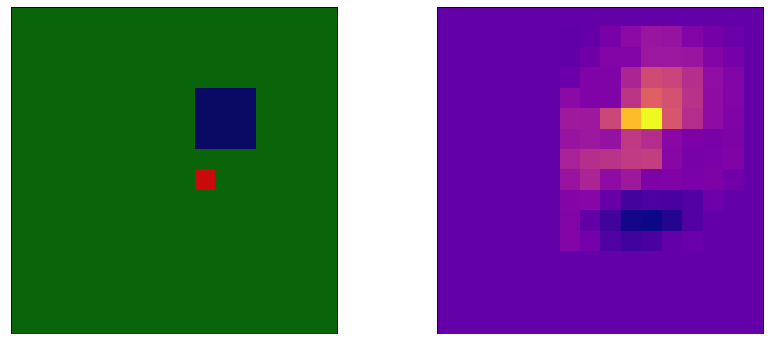

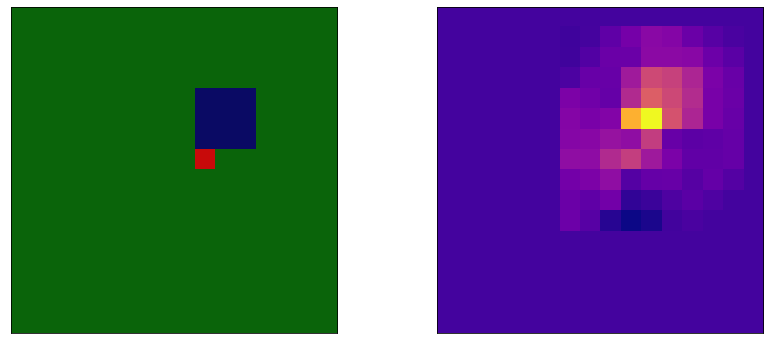

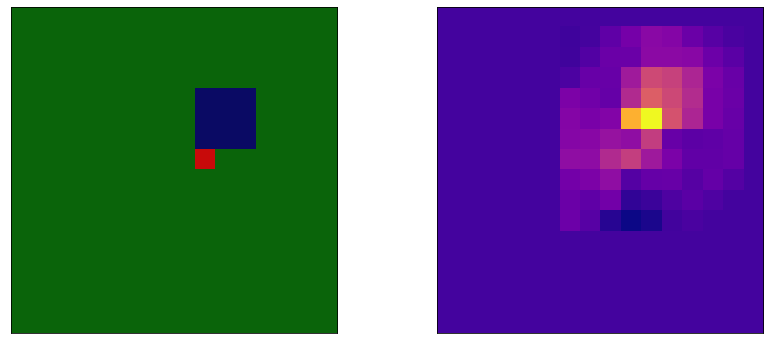

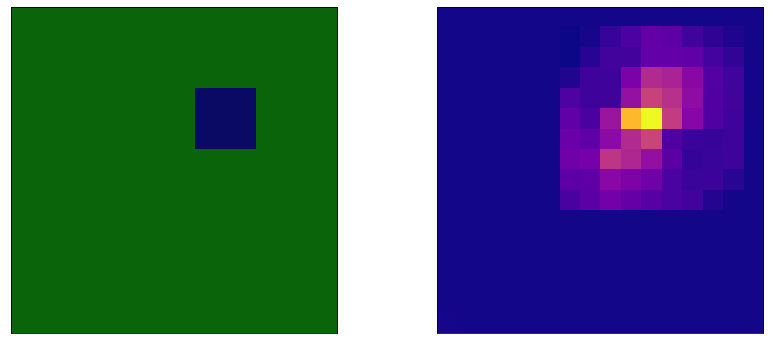

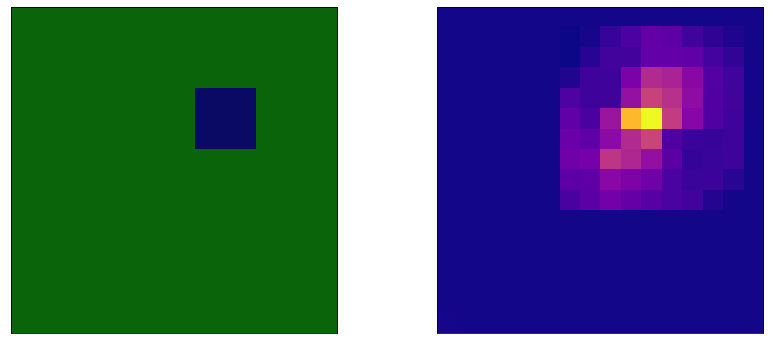

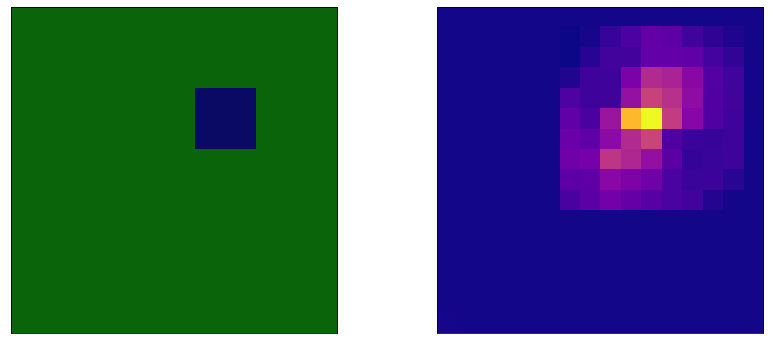

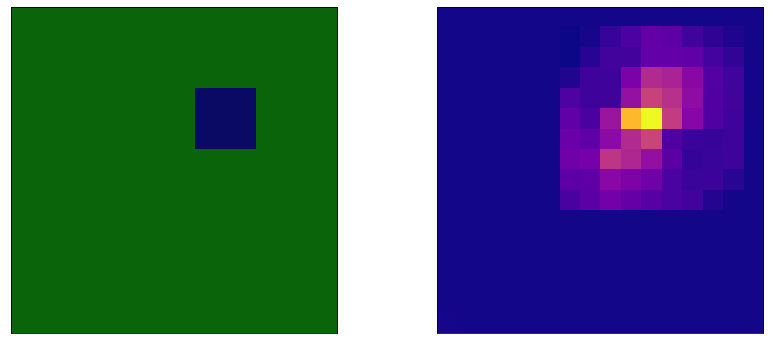

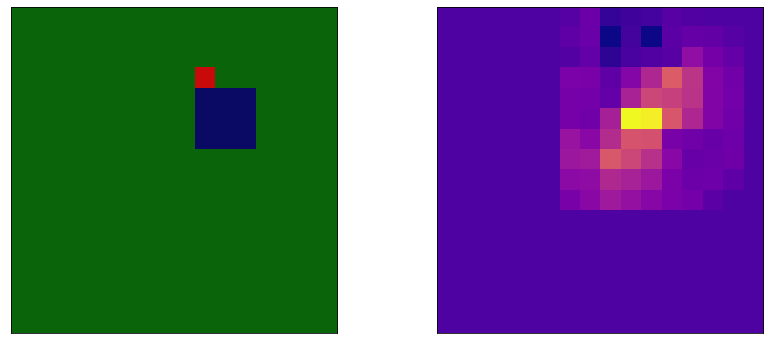

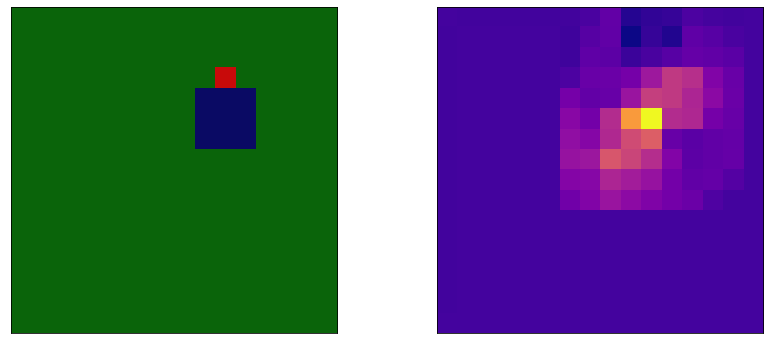

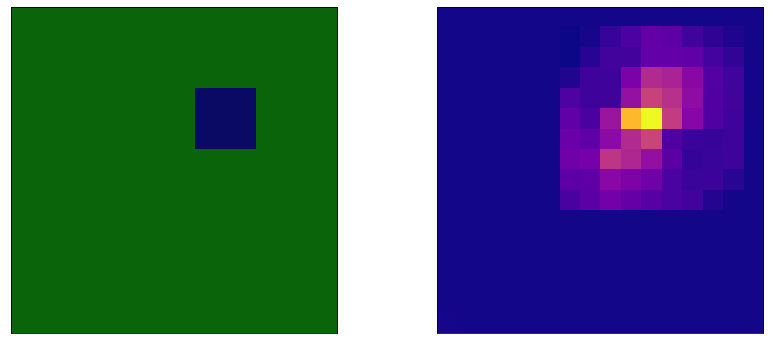

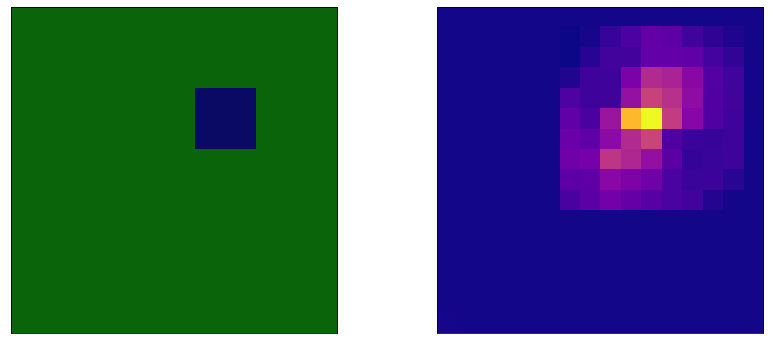

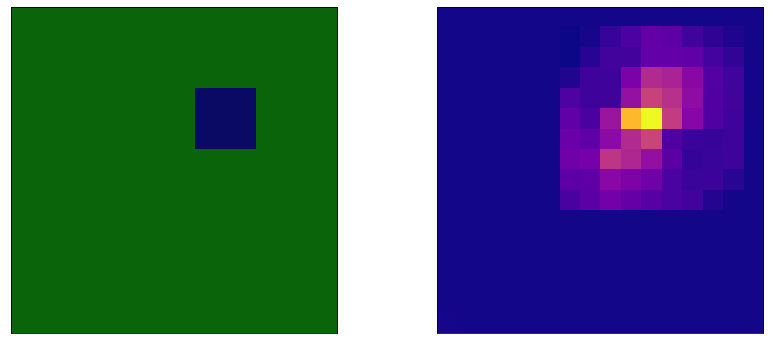

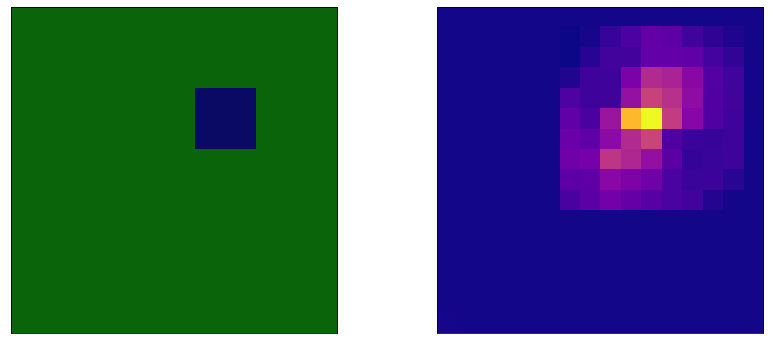

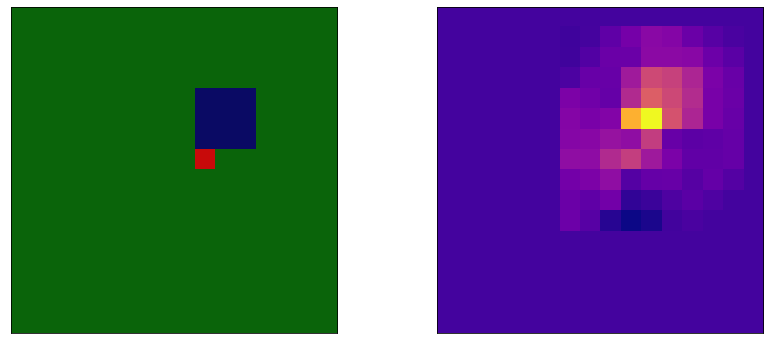

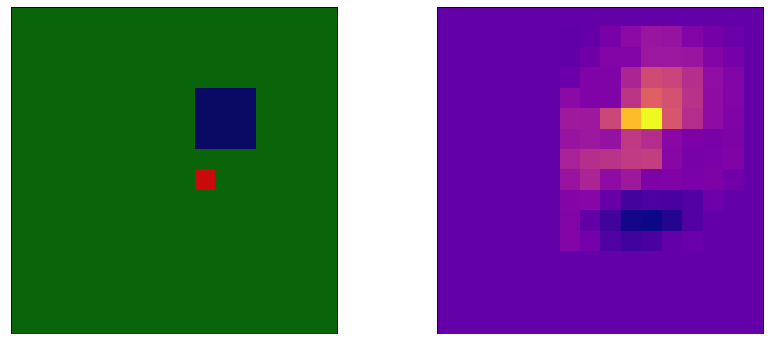

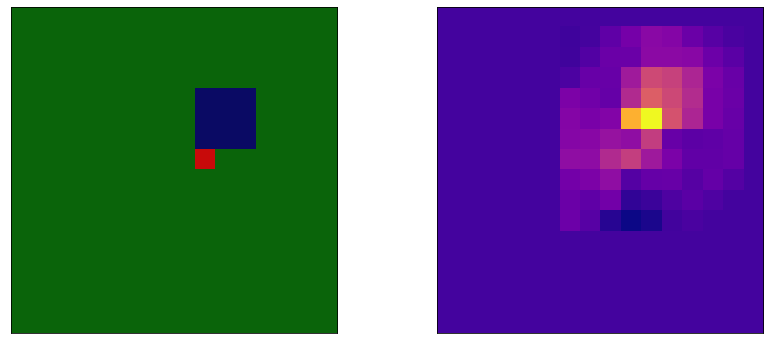

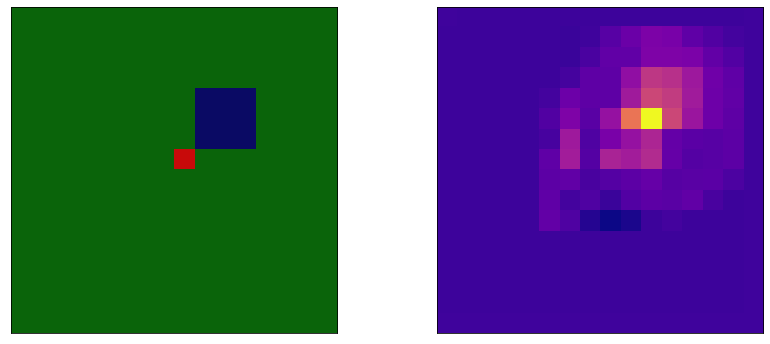

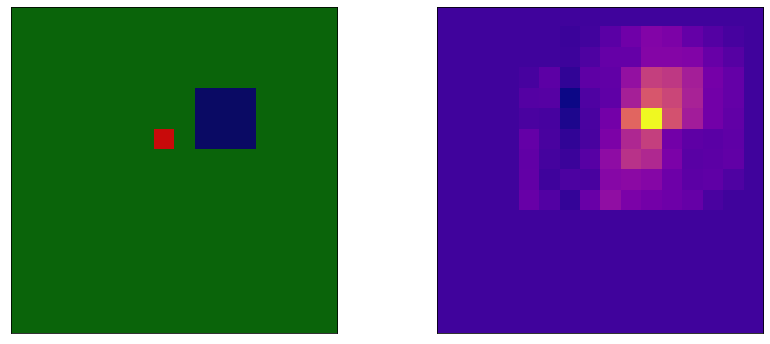

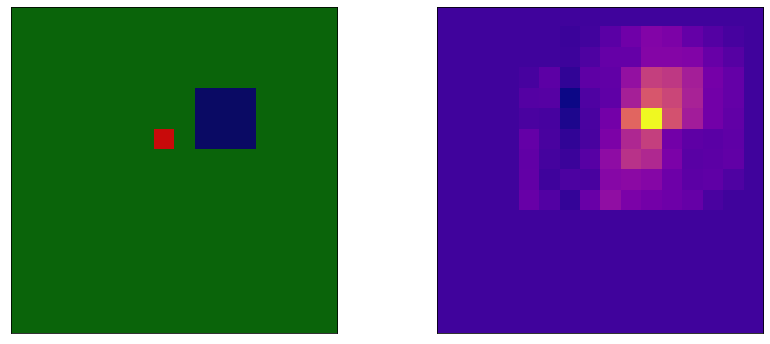

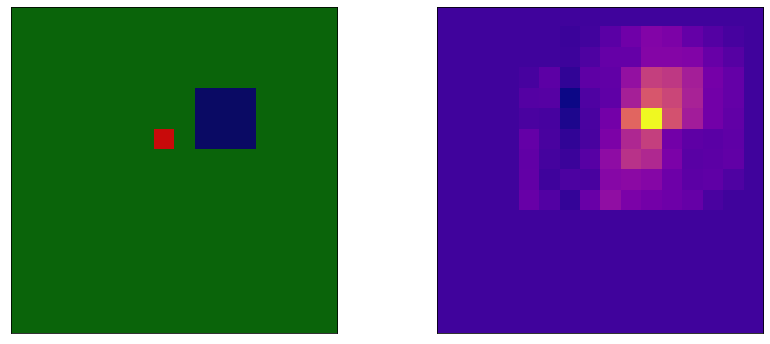

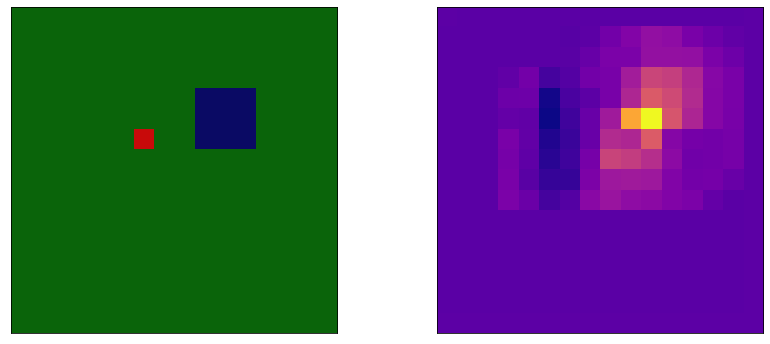

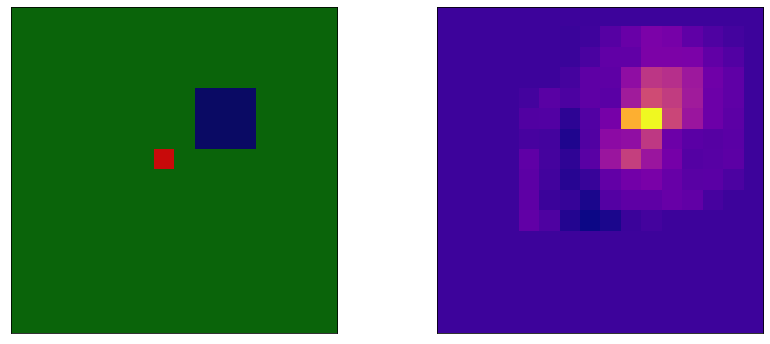

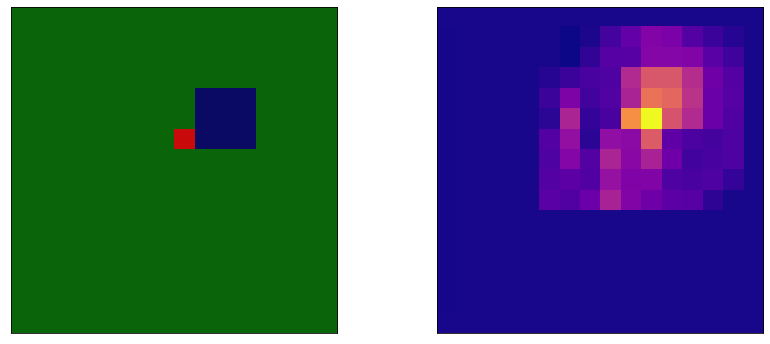

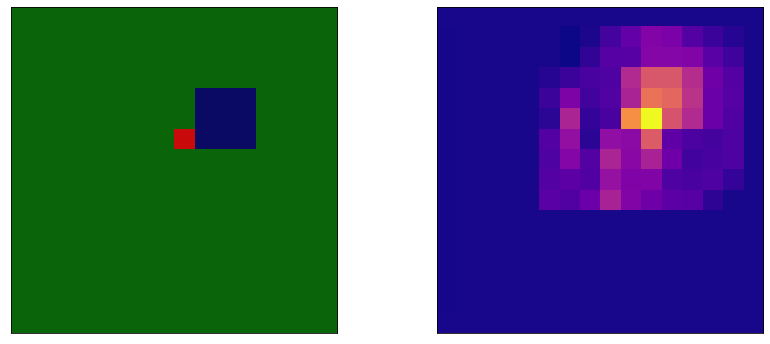

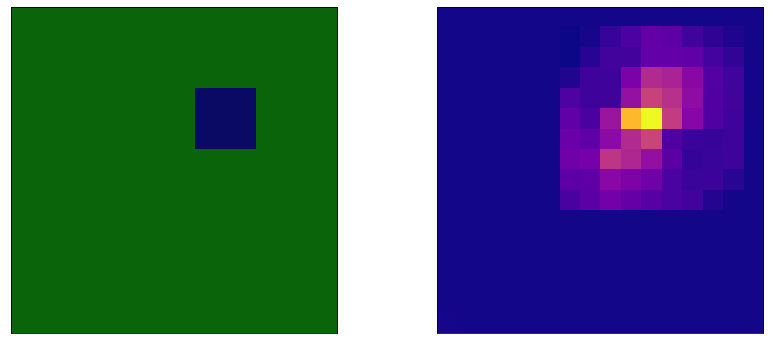

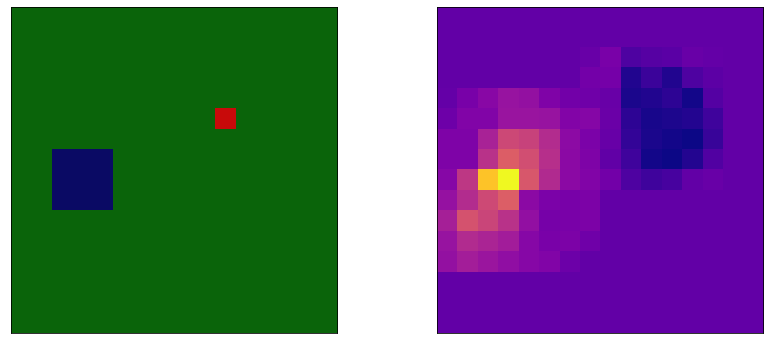

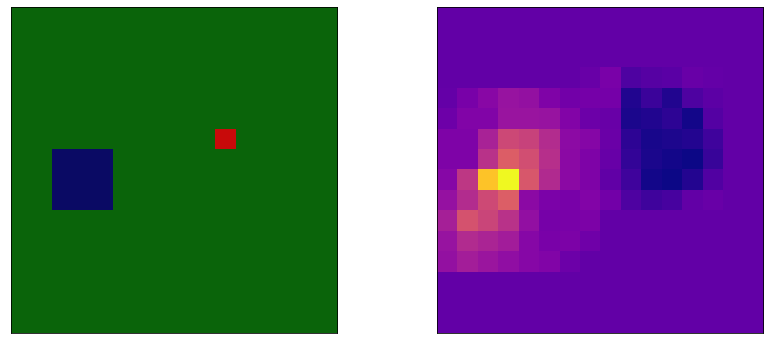

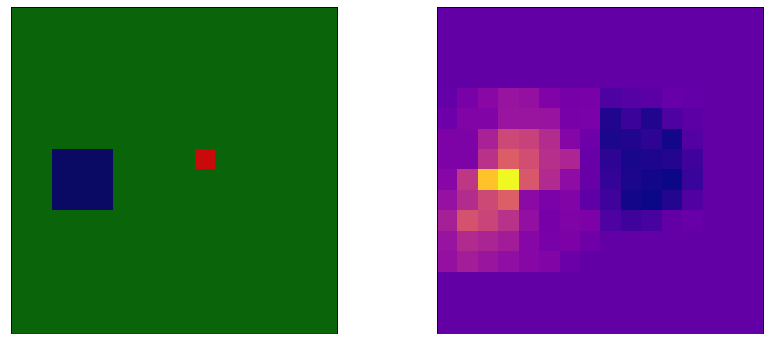

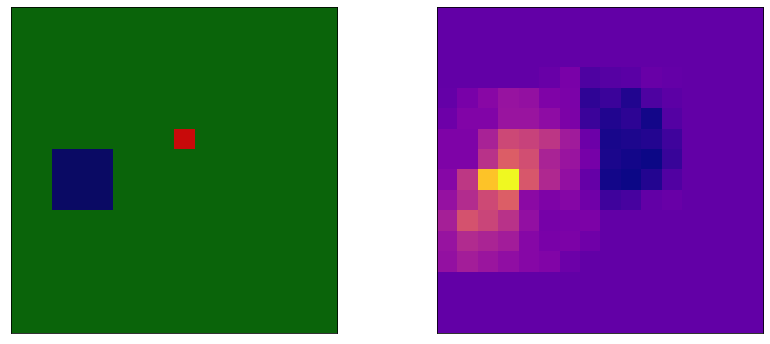

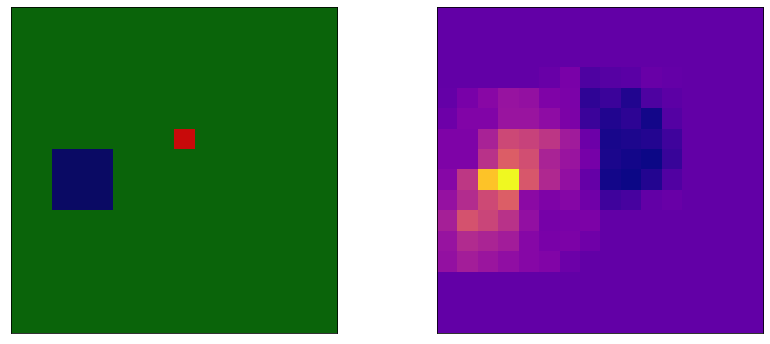

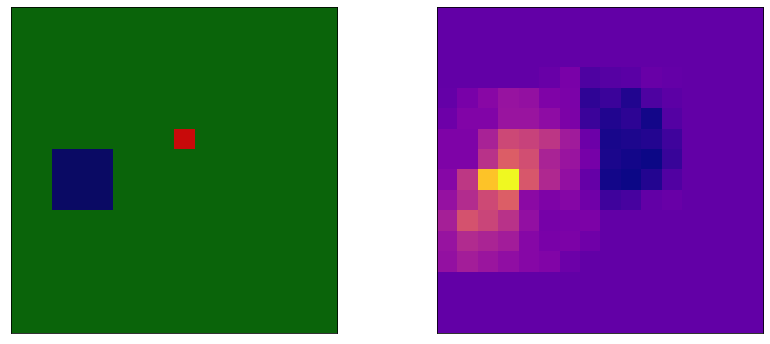

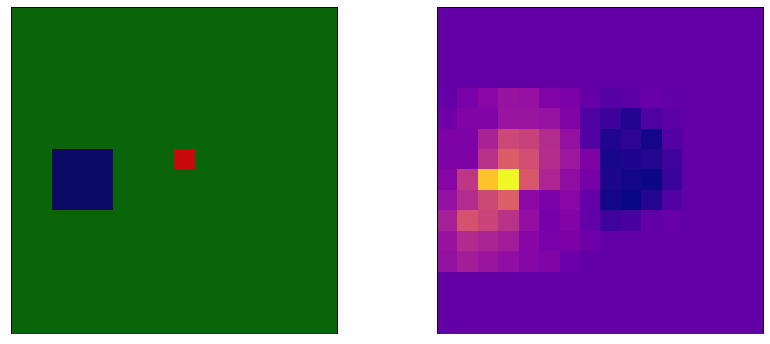

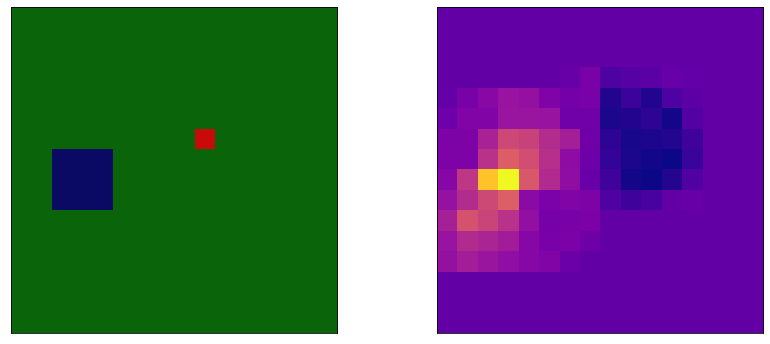

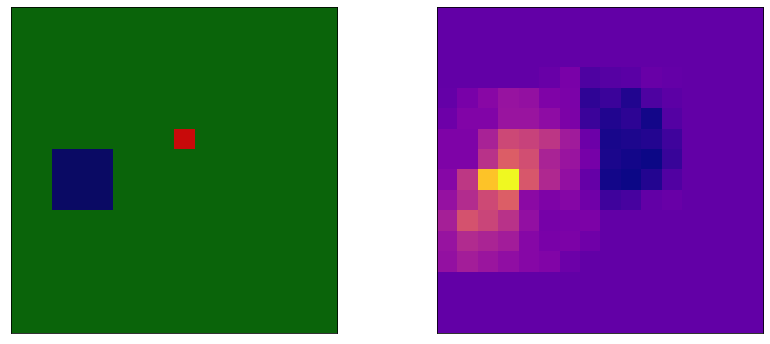

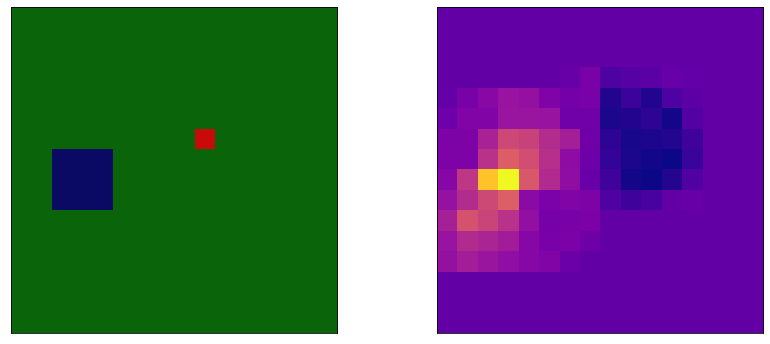

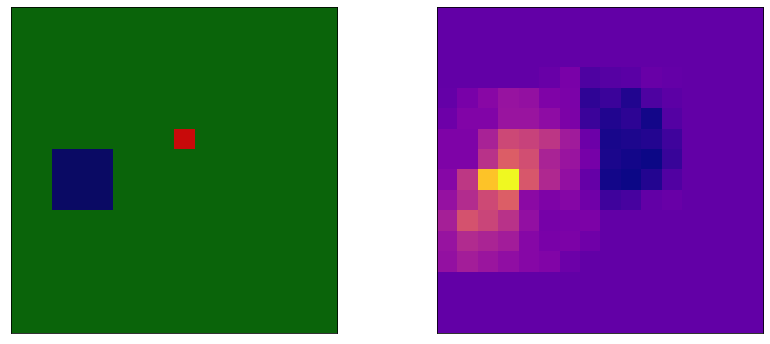

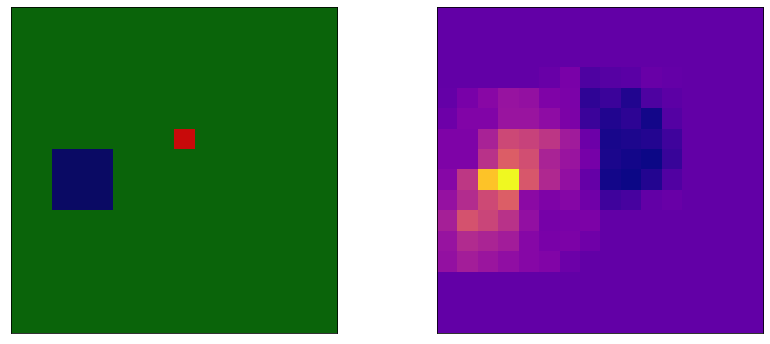

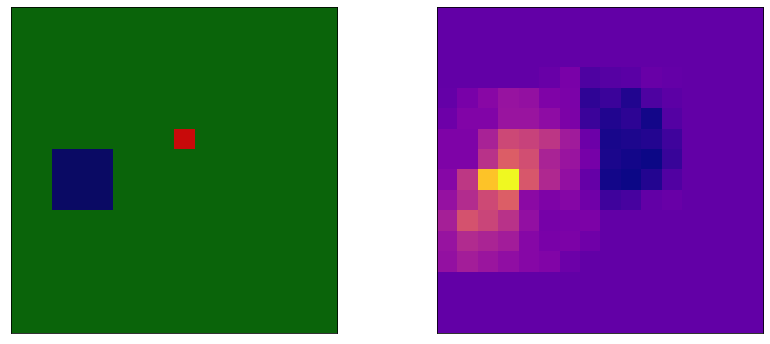

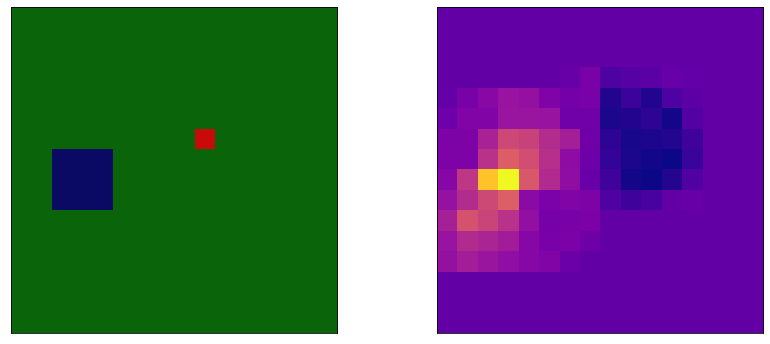

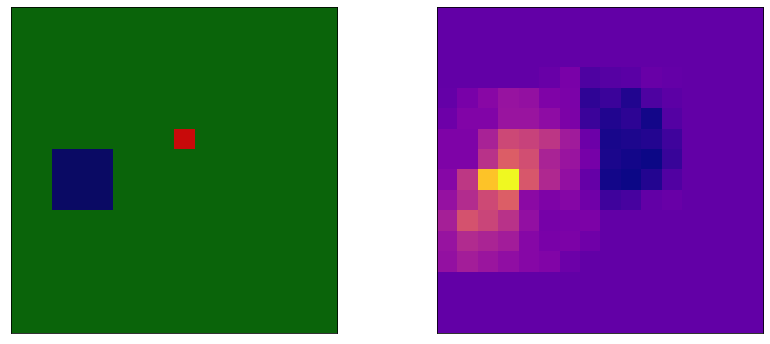

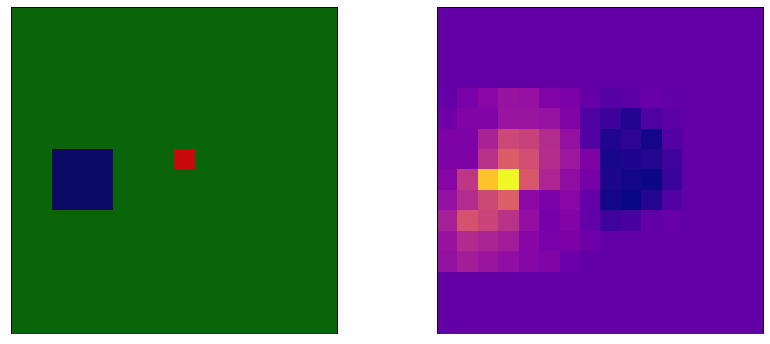

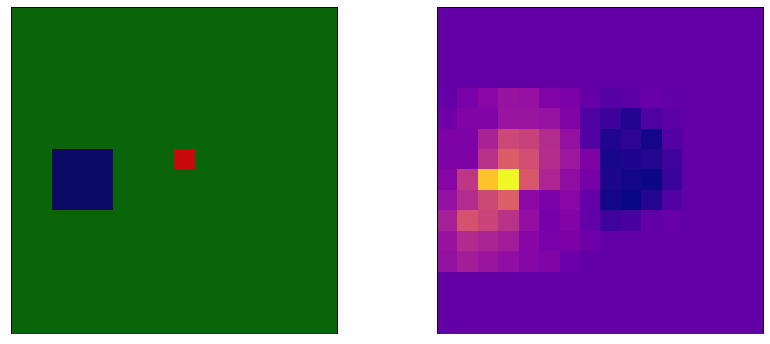

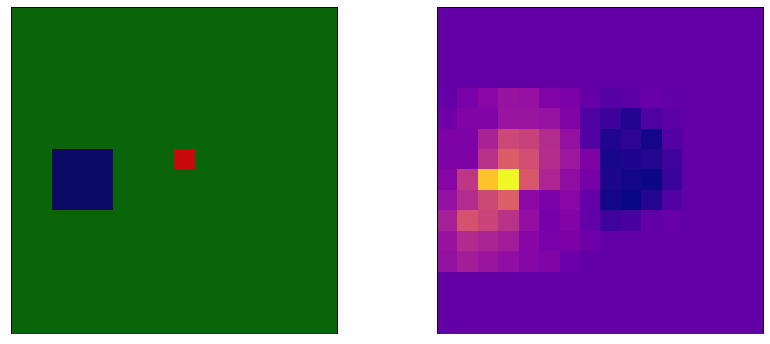

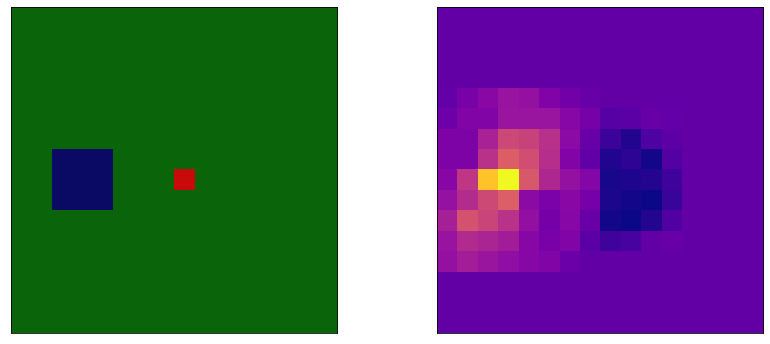

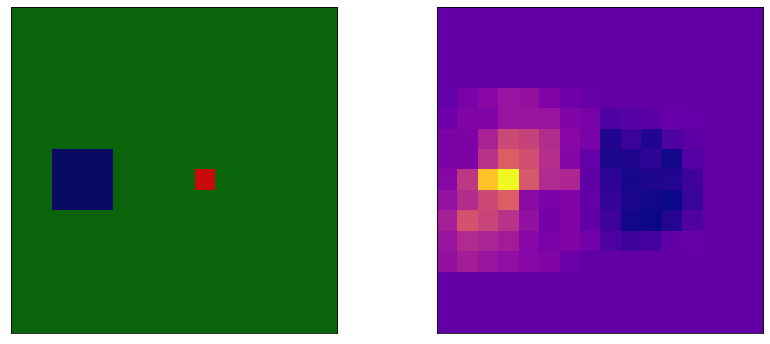

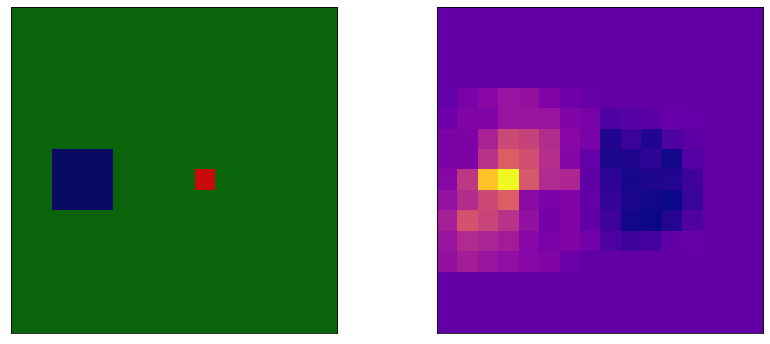

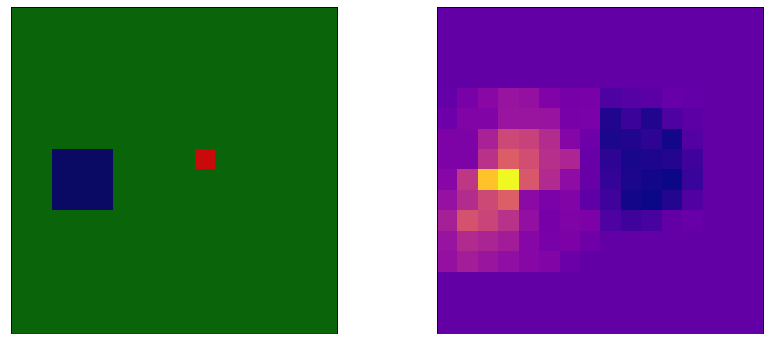

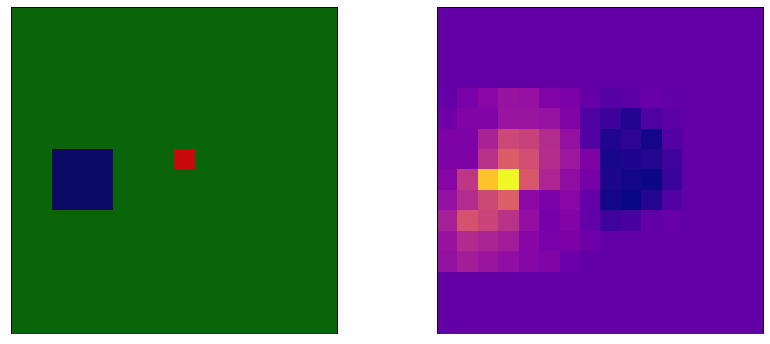

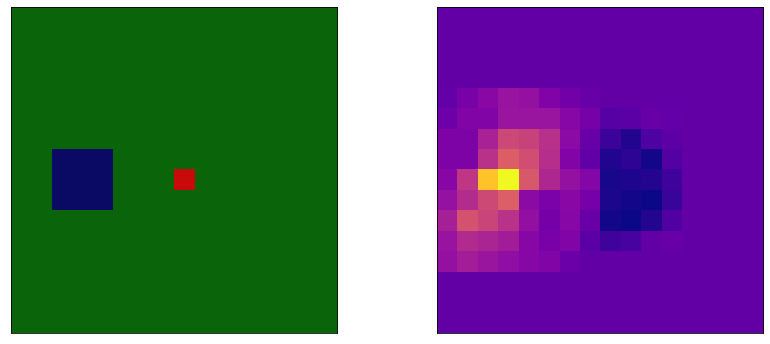

In [110]:
for t in range(len(inspector.dict['state_traj'])):
    plot_screen_and_decision(inspector.dict, t)